In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import math
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import argparse
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import os
import sys

In [2]:
import random
import numpy as np
import torch

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

torch_fix_seed()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.0.0+cu117
device: cuda


In [4]:
#dataset loading
class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
mean = (0.5,)
std = (0.5,)
train_images = ImageFolder( "../data/unet_train", transform = ImageTransform(mean, std))
train_loader = DataLoader(train_images, batch_size = 16, shuffle = False, drop_last=True)
val_images = ImageFolder( "../data/unet_val", transform = ImageTransform(mean, std))
val_loader = DataLoader(val_images, batch_size = 16, shuffle = False, drop_last=True)

In [5]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv9 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv10 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.conv11 = nn.Conv2d(1024, 512, 2, padding="same")
        self.conv12 = nn.Conv2d(1024, 512, 3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv14 = nn.Conv2d(512, 256, 2, padding="same")
        self.conv15 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv16 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv17 = nn.Conv2d(256, 128, 2, padding="same")
        self.conv18 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv19 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv20 = nn.Conv2d(128, 64, 2, padding="same")
        self.conv21 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv22 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv23 = nn.Conv2d(64, 2, 3, padding=1)
        self.conv24 = nn.Conv2d(2, 1, 1)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
    
        # # self.label_emb = nn.Embedding(class_num, class_num)
        
        # self.model = nn.Sequential(
        #     nn.Conv2d(1, 64, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Conv2d(64, 64, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2),
        #     nn.Conv2d(64, 128, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Conv2d(128, 128, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2),
        #     nn.Conv2d(128, 256, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Conv2d(256, 256, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2),
        #     nn.Conv2d(256, 512, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Conv2d(512, 512, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Dropout(0.5),
        #     nn.MaxPool2d(2),
        #     nn.Conv2d(512, 1024, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Conv2d(1024, 1024, 3, padding=1),
        #     nn.ReLU(True),
        #     nn.Dropout(0.5),
        #     nn.Conv2d(1024, 512, 3, padding=1),
        #     nn.ReLU(True),


        #     nn.ConvTranspose2d(self.z_size + 26, ngf * 32, 4, 1, 0, bias=False),
        #     nn.BatchNorm2d(ngf * 32),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ngf * 16),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ngf * 8),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ngf * 4),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        #     nn.BatchNorm2d(ngf * 2),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
        #     nn.BatchNorm2d(ngf),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(ngf, 1, 3, 1, 1, bias=False),
        #     nn.Tanh()
        # )
    
    def forward(self, x):

        conv1 = self.conv1(x)
        conv1 = self.relu(conv1)
        conv1 = self.conv2(conv1)
        conv1 = self.relu(conv1)
        pool1 = self.maxpool(conv1)
        conv2 = self.conv3(pool1)
        conv2 = self.relu(conv2)
        conv2 = self.conv4(conv2)
        conv2 = self.relu(conv2)
        pool2  =self.maxpool(conv2)
        conv3 = self.conv5(pool2)
        conv3 = self.relu(conv3)
        conv3 = self.conv6(conv3)
        conv3 = self.relu(conv3)
        pool3 = self.maxpool(conv3)
        conv4 = self.conv7(pool3)
        conv4 = self.relu(conv4)
        conv4 = self.conv8(conv4)
        conv4 = self.relu(conv4)
        drop4 = self.dropout(conv4)
        pool4 = self.maxpool(drop4)
        conv5 = self.conv9(pool4)
        conv5 = self.relu(conv5)
        conv5 = self.conv10(conv5)
        conv5 = self.relu(conv5)
        drop5 = self.dropout(conv5)
        up6 = self.up(drop5)
        up6 = self.conv11(up6)
        up6 = self.relu(up6)
        merge6 = torch.cat((drop4, up6), 1)
        conv6 = self.conv12(merge6)
        conv6 = self.relu(conv6)
        conv6 = self.conv13(conv6)
        conv6 = self.relu(conv6)
        up7 = self.up(conv6)
        up7 = self.conv14(up7)
        up7 = self.relu(up7)
        merge7 = torch.cat((conv3, up7), 1)
        conv7 = self.conv15(merge7)
        conv7 = self.relu(conv7)
        conv7 = self.conv16(conv7)
        conv7 = self.relu(conv7)
        up8 = self.up(conv7)
        up8 = self.conv17(up8)
        up8 = self.relu(up8)
        merge8 = torch.cat((conv2, up8), 1)
        conv8 = self.conv18(merge8)
        conv8 = self.relu(conv8)
        conv8 = self.conv19(conv8)
        conv8 = self.relu(conv8)
        up9 = self.up(conv8)
        up9 = self.conv20(up9)
        up9 = self.relu(up9)
        merge9 = torch.cat((conv1, up9), 1)
        conv9 = self.conv21(merge9)
        conv9 = self.relu(conv9)
        conv9 = self.conv22(conv9)
        conv9 = self.relu(conv9)
        conv9 = self.conv23(conv9)
        conv9 = self.relu(conv9)
        conv10 = self.conv24(conv9)
        output = self.tanh(conv10)
        
        return output

In [6]:
pretrained_model = "../model/googlefonts.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

for param in model.parameters():
    param.requires_grad = False

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


In [7]:
unet = Unet().to(device)

In [8]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

In [9]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()


def calc_loss(pred, target, metrics=None, bce_weight=0.5):
    # Dice LossとCategorical Cross Entropyを混ぜていい感じにしている
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    return loss

In [10]:
def train(epoch):
    unet.train()
    for batch_idx, (image, target) in enumerate(train_loader):
        unet.train()
        optimizer.zero_grad()
        image, target = Variable(image).to(device), Variable(target.to(device))
        generated = unet(image)
        output = model(generated)
        loss1 = F.nll_loss(output, target)
        loss2 = F.mse_loss(generated, image)
        loss = loss2
        loss.backward()
        optimizer.step()
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch + 1, batch_idx * len(image), len(image) * len(train_loader),
        #         100. * batch_idx / len(train_loader), loss.item()))
        #     print("loss1:{}  loss2:{}".format(loss1, loss2))
        # if batch_idx == 38 and epoch == 0:
        #     # print(image)
        #     # print(generated)
        #     generated = (generated + 1) / 2
        #     grid = make_grid(image.data.cpu(), nrow=16, normalize=False).permute(1,2,0).numpy()
        #     fig, ax = plt.subplots(figsize=(26,26))
        #     plt.imshow(grid)
        #     plt.clim(0, 1)
        #     plt.show()
        # if batch_idx == 38:
        #     # print(image)
        #     # print(generated)
        #     generated = (generated + 1) / 2
        #     grid = make_grid(generated.data.cpu(), nrow=16, normalize=False).permute(1,2,0).numpy()
        #     fig, ax = plt.subplots(figsize=(26,26))
        #     plt.imshow(grid)
        #     plt.clim(0, 1)
        #     plt.show()

In [11]:
def val(epoch):
    unet.eval()
    val_loss1 = 0
    val_loss2 = 0
    with torch.no_grad():
        for image, target in val_loader:
            image, target = Variable(image).to(device), Variable(target.to(device))
            generated = unet(image)
            output = model(generated)
            loss1 = F.nll_loss(output, target)
            loss2 = F.mse_loss(generated, image)
            val_loss1 += loss1.item()
            val_loss2 += loss2.item()
    val_loss1 /= len(val_loader)
    val_loss2 /= len(val_loader)
    
    if epoch == 0:
        grid = make_grid(image.data.cpu(), nrow=16, normalize=False).permute(1,2,0).numpy()
        fig, ax = plt.subplots(figsize=(26,26))
        plt.imshow(grid)
        plt.clim(0, 1)
        plt.show()
    generated = (generated + 1) / 2
    grid = make_grid(generated.data.cpu(), nrow=16, normalize=False).permute(1,2,0).numpy()
    fig, ax = plt.subplots(figsize=(26,26))
    plt.imshow(grid)
    plt.clim(0, 1)
    plt.show()
    
    print("\nVal set: Average total loss: {:.4f}, Average loss1: {:.4f}, Average loss2: {:.4f}".format(val_loss1 + val_loss2, val_loss1, val_loss2))
    return val_loss2
    # return val_loss1, val_loss2

In [12]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=5, verbose=False, path='../model/unet2.pth'):
        """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

        self.patience = patience    #設定ストップカウンタ
        self.verbose = verbose      #表示の有無
        self.counter = 0            #現在のカウンタ値
        self.best_score = None      #ベストスコア
        self.early_stop = False     #ストップフラグ
        self.val_loss_min = np.Inf   #前回のベストスコア記憶用
        self.path = path             #ベストモデル格納path

    def __call__(self, val_loss, model):
        """
        特殊(call)メソッド
        実際に学習ループ内で最小lossを更新したか否かを計算させる部分
        """
        score = -val_loss

        if self.best_score is None:  #1Epoch目の処理
            self.best_score = score   #1Epoch目はそのままベストスコアとして記録する
            self.checkpoint(val_loss, model)  #記録後にモデルを保存してスコア表示する
        elif score < self.best_score:  # ベストスコアを更新できなかった場合
            self.counter += 1   #ストップカウンタを+1
            if self.verbose:  #表示を有効にした場合は経過を表示
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
            if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
        else:  #ベストスコアを更新した場合
            self.best_score = score  #ベストスコアを上書き
            self.checkpoint(val_loss, model)  #モデルを保存してスコア表示
            self.counter = 0  #ストップカウンタリセット

    def checkpoint(self, val_loss, model):
        '''ベストスコア更新時に実行されるチェックポイント関数'''
        if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
        self.val_loss_min = val_loss  #その時のlossを記録する

In [13]:
# class EarlyStopping:
#     """earlystoppingクラス"""

#     def __init__(self, patience=5, verbose=False, path='../unet.pth'):
#         """引数：最小値の非更新数カウンタ、表示設定、モデル格納path"""

#         self.patience = patience    #設定ストップカウンタ
#         self.verbose = verbose      #表示の有無
#         self.counter = 0            #現在のカウンタ値
#         self.best_score1 = None      #ベストスコア
#         self.best_score2 = None
#         self.early_stop = False     #ストップフラグ
#         self.val_loss1_min = np.Inf   #前回のベストスコア記憶用
#         self.val_loss2_min = np.Inf
#         self.path = path             #ベストモデル格納path

#     def __call__(self, val_loss1, val_loss2, model):
#         """
#         特殊(call)メソッド
#         実際に学習ループ内で最小lossを更新したか否かを計算させる部分
#         """
#         score1 = -val_loss1
#         score2 = -val_loss2

#         if self.best_score1 is None and self.best_score2 is None:  #1Epoch目の処理
#             self.best_score1 = score1   #1Epoch目はそのままベストスコアとして記録する
#             self.best_score2 = score2
#             self.checkpoint(val_loss1, val_loss2, model)  #記録後にモデルを保存してスコア表示する
#         elif score1 < self.best_score1 or score2 < self.best_score2:
#         # elif score2 < self.best_score2:  # ベストスコアを更新できなかった場合
#             self.counter += 1   #ストップカウンタを+1
#             if self.verbose:  #表示を有効にした場合は経過を表示
#                 print(f'EarlyStopping counter: {self.counter} out of {self.patience}')  #現在のカウンタを表示する 
#             if self.counter >= self.patience:  #設定カウントを上回ったらストップフラグをTrueに変更
#                 self.early_stop = True
#         else:  #ベストスコアを更新した場合
#             self.best_score1 = score1  #ベストスコアを上書き
#             self.best_score2 = score2
#             self.checkpoint(val_loss1, val_loss2, model)  #モデルを保存してスコア表示
#             self.counter = 0  #ストップカウンタリセット

#     def checkpoint(self, val_loss1, val_loss2, model):
#         '''ベストスコア更新時に実行されるチェックポイント関数'''
#         if self.verbose:  #表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
#             print(f'Validation loss decreased [loss1]({self.val_loss1_min:.6f} --> {val_loss1:.6f}), [loss2]({self.val_loss2_min:.6f} --> {val_loss2:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), self.path)  #ベストモデルを指定したpathに保存
#         self.val_loss1_min = val_loss1  #その時のlossを記録する
#         self.val_loss2_min = val_loss2

In [14]:
scheduler = StepLR(optimizer, step_size=20, gamma=0.8)
earlystopping = EarlyStopping(patience=10, verbose=True)

Starting epoch 1...


/home/hoge/.local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/hoge/.local/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)


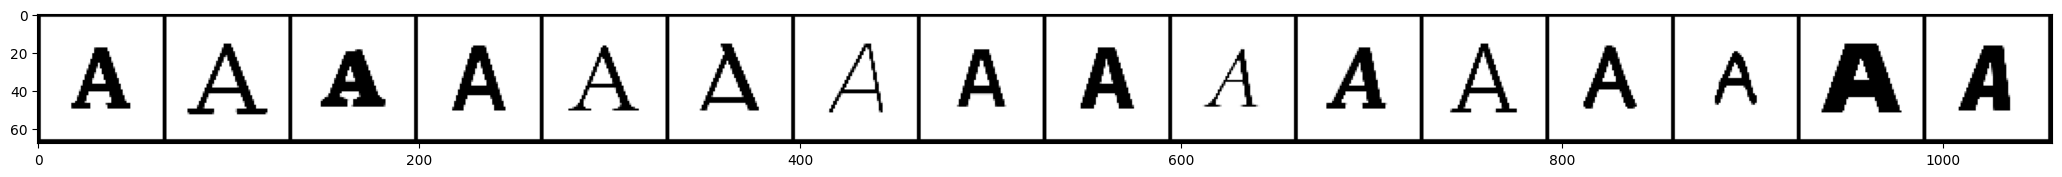

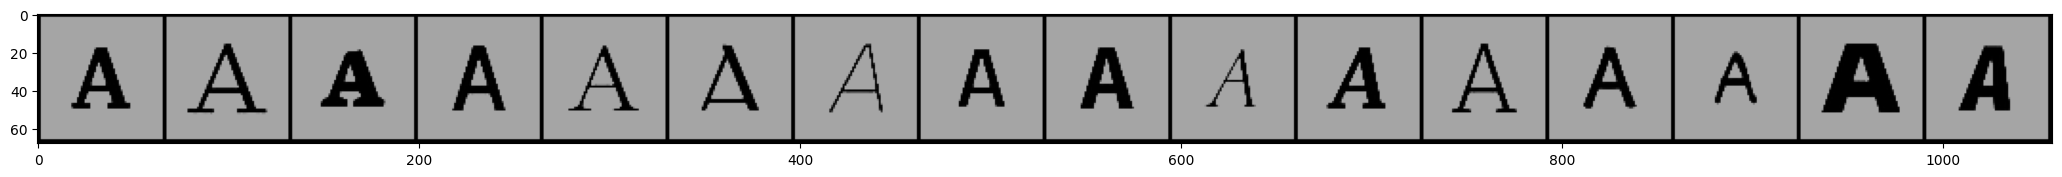


Val set: Average total loss: 0.7539, Average loss1: 0.3052, Average loss2: 0.4487
Validation loss decreased (inf --> 0.448689).  Saving model ...
Starting epoch 2...


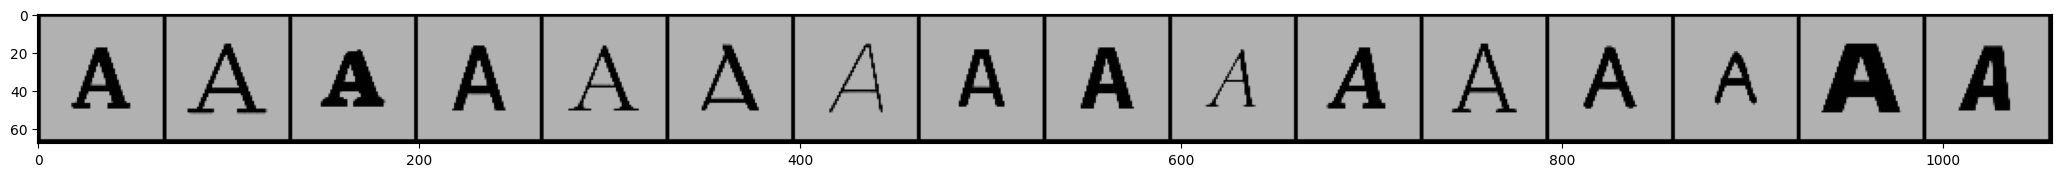


Val set: Average total loss: 0.5909, Average loss1: 0.2563, Average loss2: 0.3346
Validation loss decreased (0.448689 --> 0.334596).  Saving model ...
Starting epoch 3...


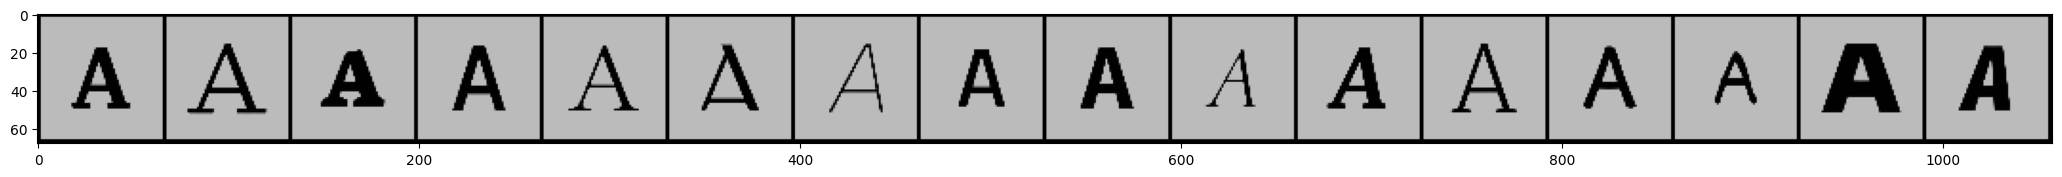


Val set: Average total loss: 0.4882, Average loss1: 0.2343, Average loss2: 0.2539
Validation loss decreased (0.334596 --> 0.253945).  Saving model ...
Starting epoch 4...


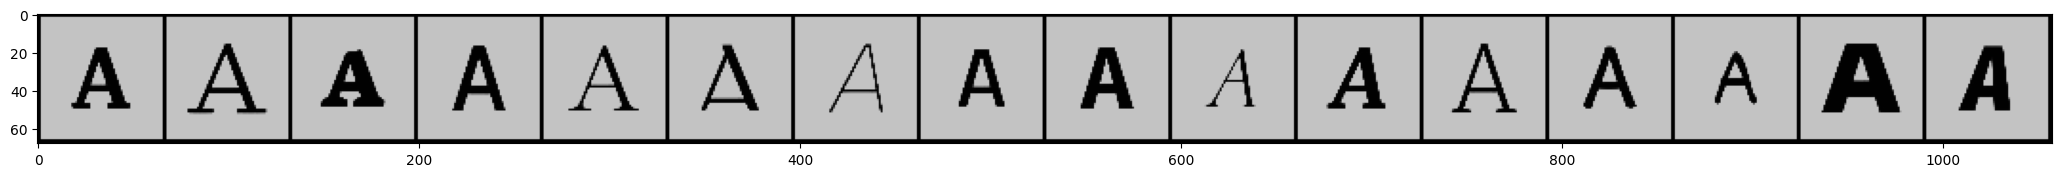


Val set: Average total loss: 0.4263, Average loss1: 0.2296, Average loss2: 0.1967
Validation loss decreased (0.253945 --> 0.196707).  Saving model ...
Starting epoch 5...


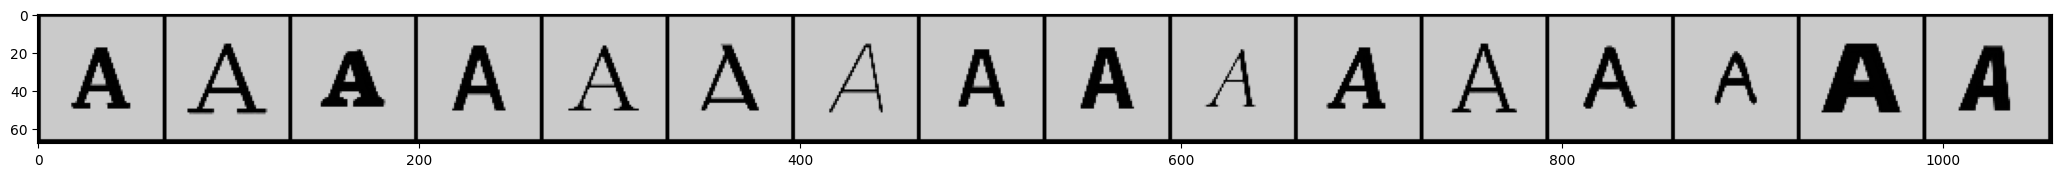


Val set: Average total loss: 0.3703, Average loss1: 0.2153, Average loss2: 0.1550
Validation loss decreased (0.196707 --> 0.154975).  Saving model ...
Starting epoch 6...


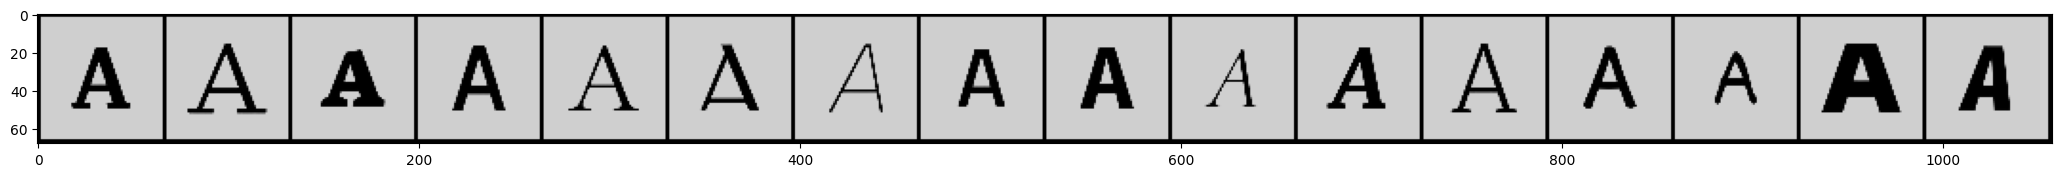


Val set: Average total loss: 0.3321, Average loss1: 0.2076, Average loss2: 0.1244
Validation loss decreased (0.154975 --> 0.124433).  Saving model ...
Starting epoch 7...


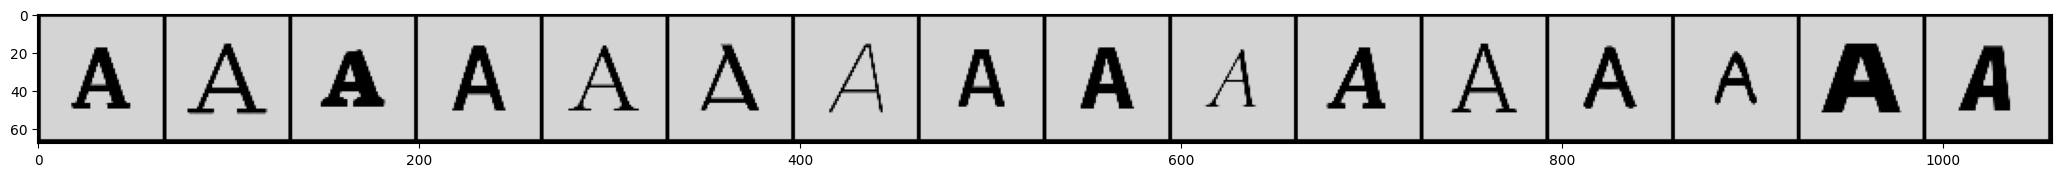


Val set: Average total loss: 0.3026, Average loss1: 0.2011, Average loss2: 0.1015
Validation loss decreased (0.124433 --> 0.101539).  Saving model ...
Starting epoch 8...


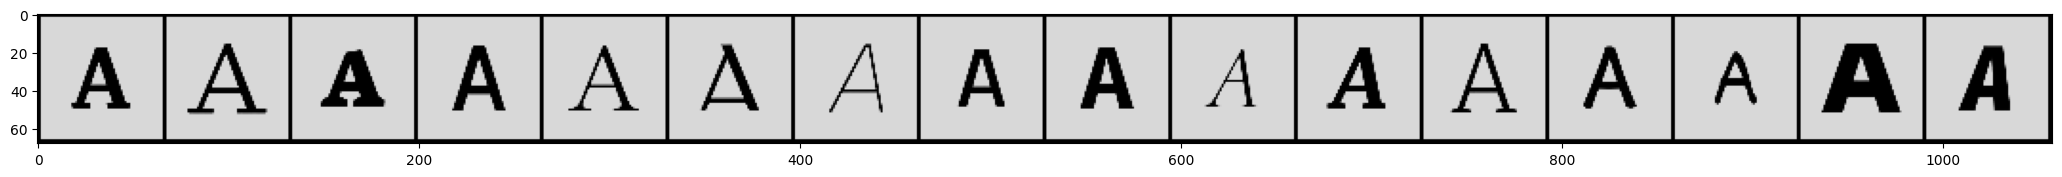


Val set: Average total loss: 0.2808, Average loss1: 0.1968, Average loss2: 0.0841
Validation loss decreased (0.101539 --> 0.084059).  Saving model ...
Starting epoch 9...


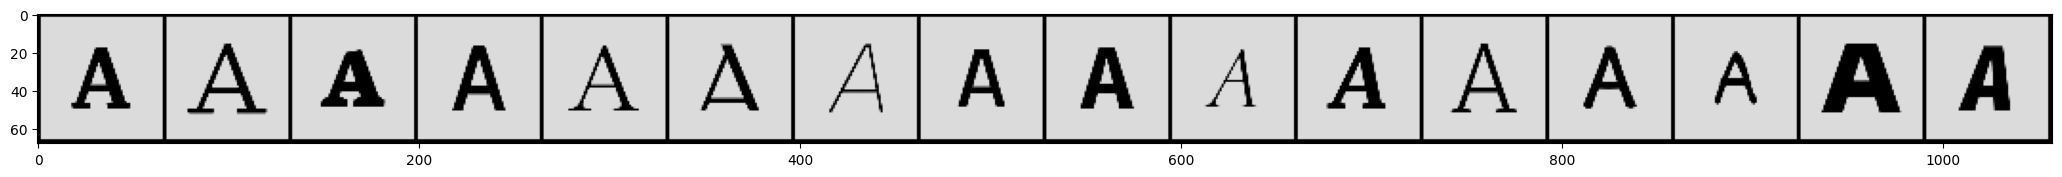


Val set: Average total loss: 0.2636, Average loss1: 0.1931, Average loss2: 0.0705
Validation loss decreased (0.084059 --> 0.070479).  Saving model ...
Starting epoch 10...


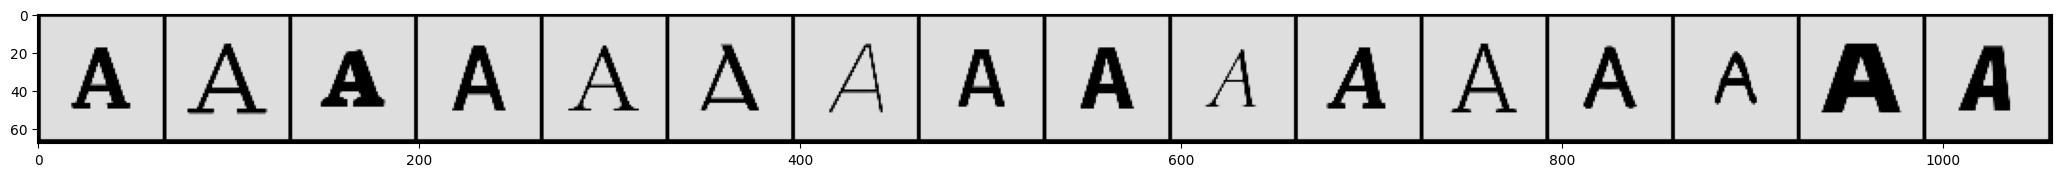


Val set: Average total loss: 0.2490, Average loss1: 0.1893, Average loss2: 0.0598
Validation loss decreased (0.070479 --> 0.059756).  Saving model ...
Starting epoch 11...


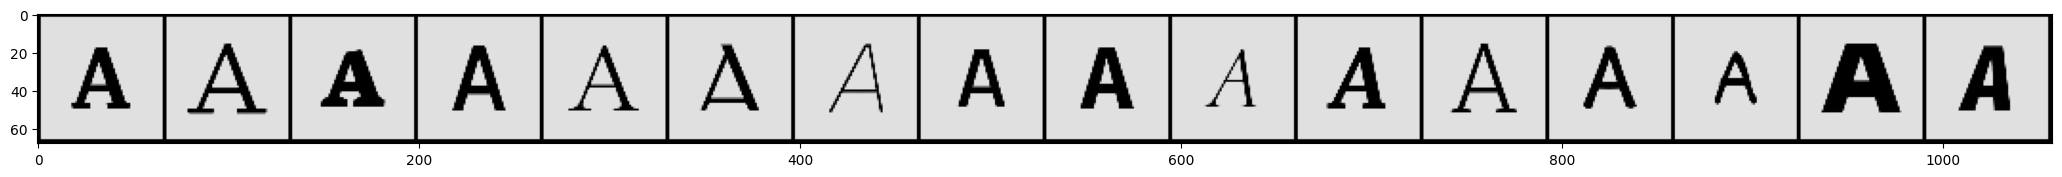


Val set: Average total loss: 0.2381, Average loss1: 0.1870, Average loss2: 0.0512
Validation loss decreased (0.059756 --> 0.051159).  Saving model ...
Starting epoch 12...


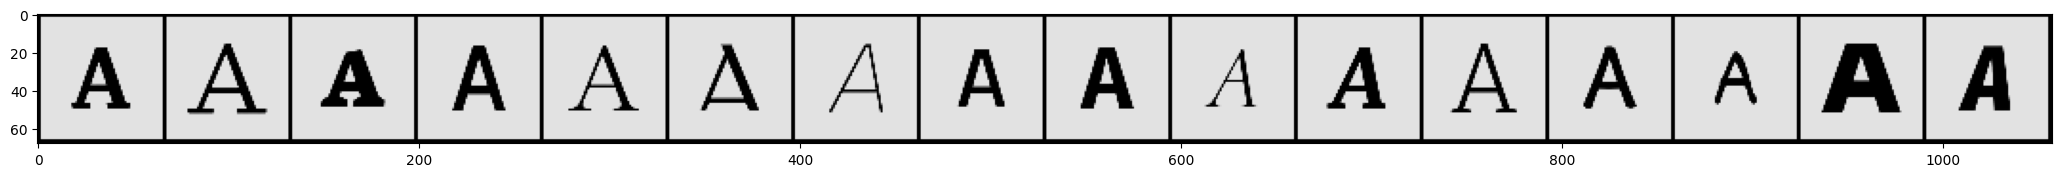


Val set: Average total loss: 0.2299, Average loss1: 0.1857, Average loss2: 0.0442
Validation loss decreased (0.051159 --> 0.044180).  Saving model ...
Starting epoch 13...


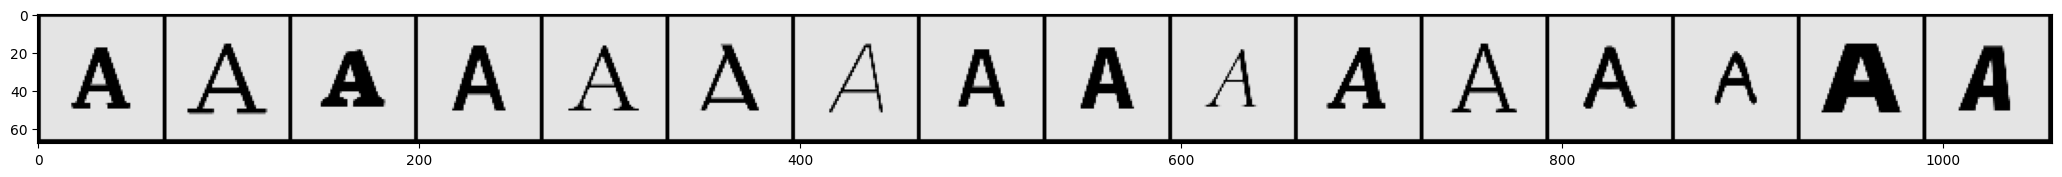


Val set: Average total loss: 0.2239, Average loss1: 0.1854, Average loss2: 0.0384
Validation loss decreased (0.044180 --> 0.038447).  Saving model ...
Starting epoch 14...


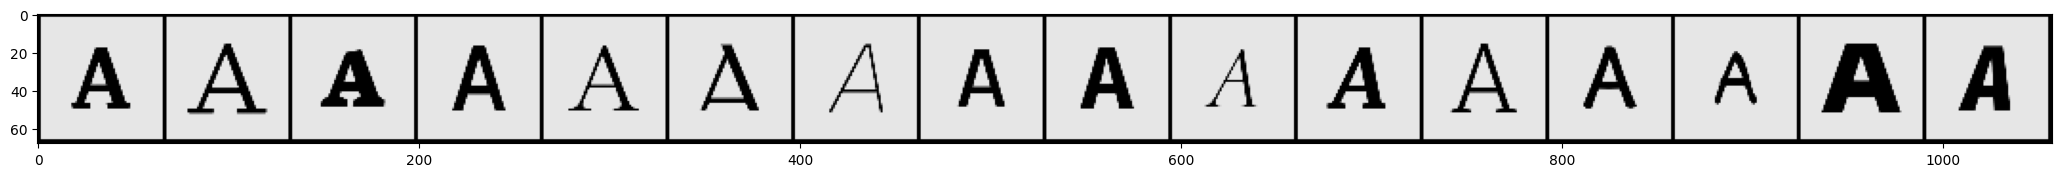


Val set: Average total loss: 0.2186, Average loss1: 0.1850, Average loss2: 0.0337
Validation loss decreased (0.038447 --> 0.033690).  Saving model ...
Starting epoch 15...


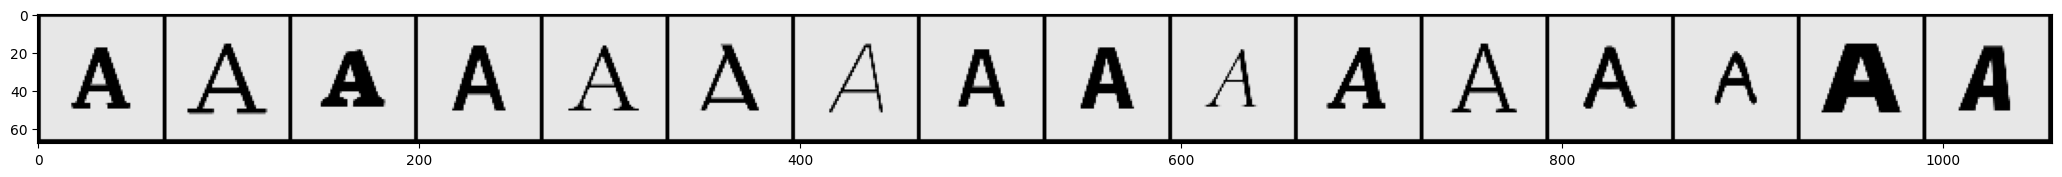


Val set: Average total loss: 0.2140, Average loss1: 0.1843, Average loss2: 0.0297
Validation loss decreased (0.033690 --> 0.029686).  Saving model ...
Starting epoch 16...


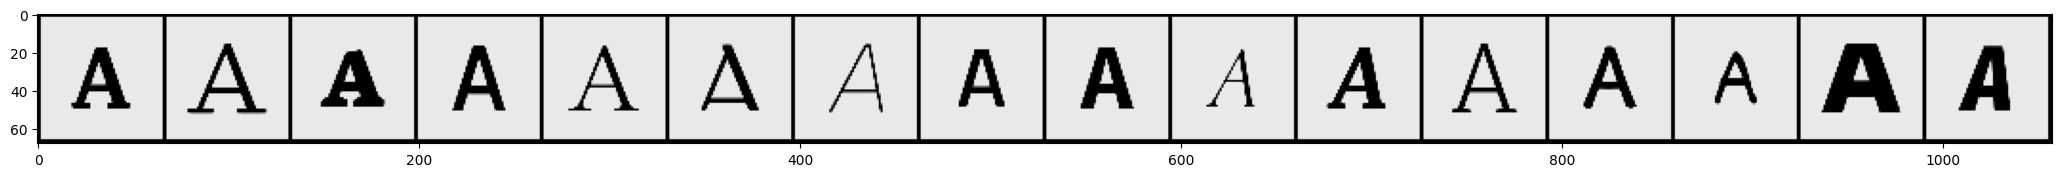


Val set: Average total loss: 0.2248, Average loss1: 0.1980, Average loss2: 0.0269
Validation loss decreased (0.029686 --> 0.026856).  Saving model ...
Starting epoch 17...


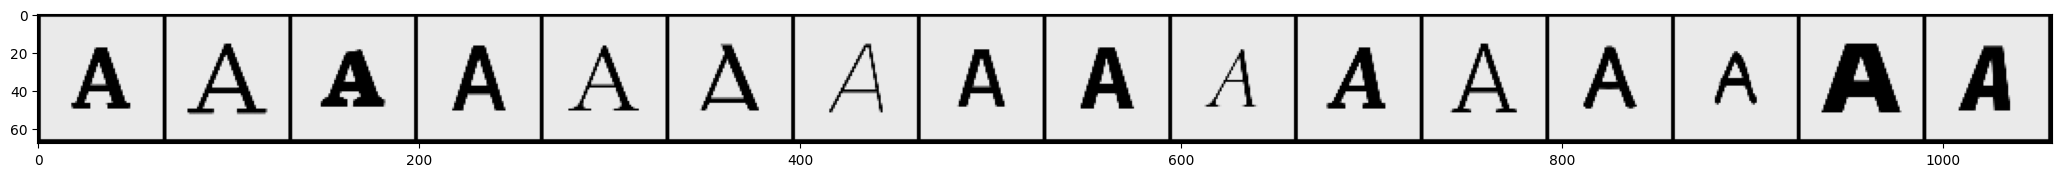


Val set: Average total loss: 0.2084, Average loss1: 0.1850, Average loss2: 0.0234
Validation loss decreased (0.026856 --> 0.023433).  Saving model ...
Starting epoch 18...


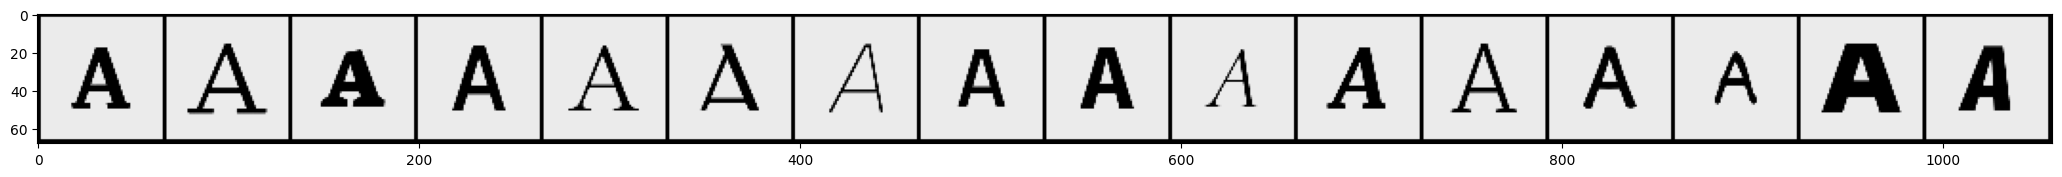


Val set: Average total loss: 0.2054, Average loss1: 0.1845, Average loss2: 0.0210
Validation loss decreased (0.023433 --> 0.020951).  Saving model ...
Starting epoch 19...


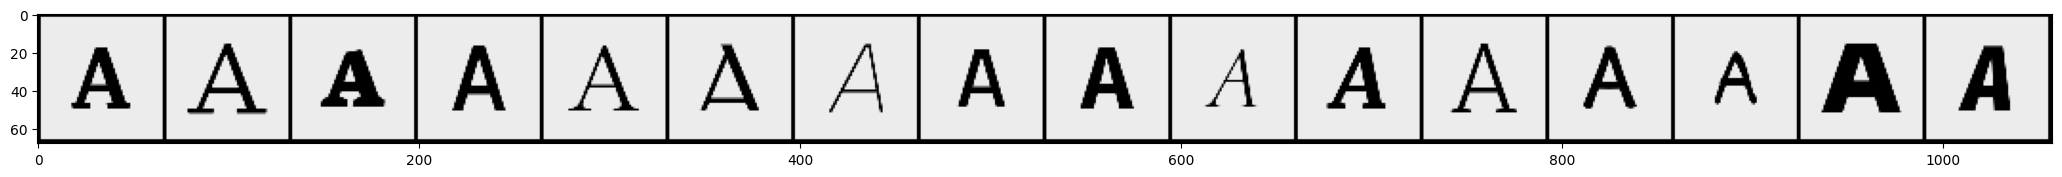


Val set: Average total loss: 0.2027, Average loss1: 0.1839, Average loss2: 0.0188
Validation loss decreased (0.020951 --> 0.018805).  Saving model ...
Starting epoch 20...


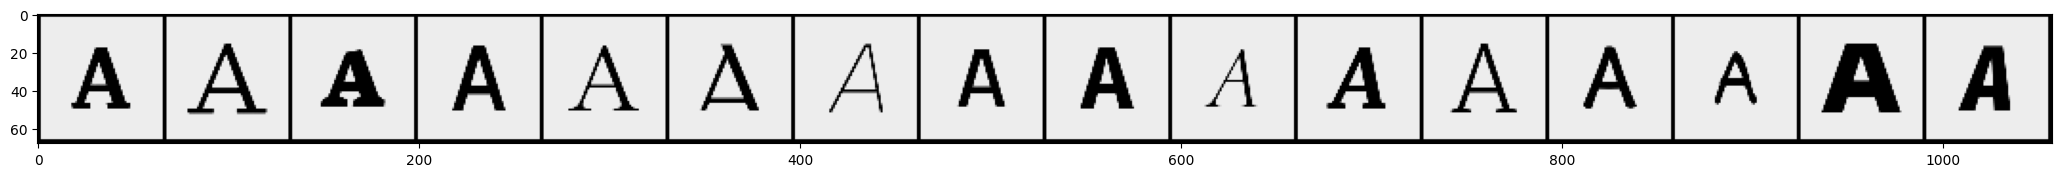


Val set: Average total loss: 0.2003, Average loss1: 0.1833, Average loss2: 0.0169
Validation loss decreased (0.018805 --> 0.016938).  Saving model ...
Starting epoch 21...


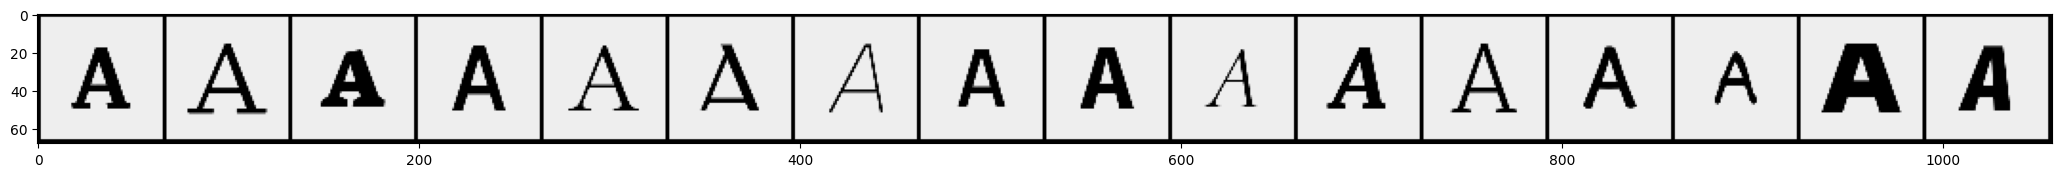


Val set: Average total loss: 0.1986, Average loss1: 0.1830, Average loss2: 0.0156
Validation loss decreased (0.016938 --> 0.015608).  Saving model ...
Starting epoch 22...


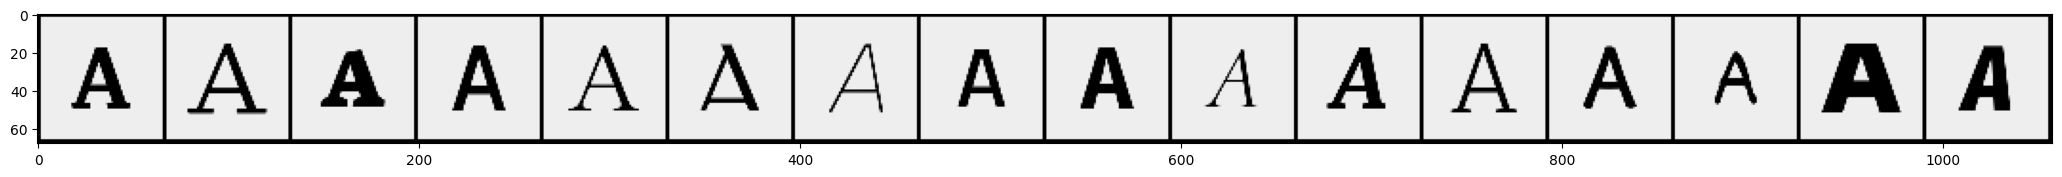


Val set: Average total loss: 0.1971, Average loss1: 0.1827, Average loss2: 0.0144
Validation loss decreased (0.015608 --> 0.014397).  Saving model ...
Starting epoch 23...


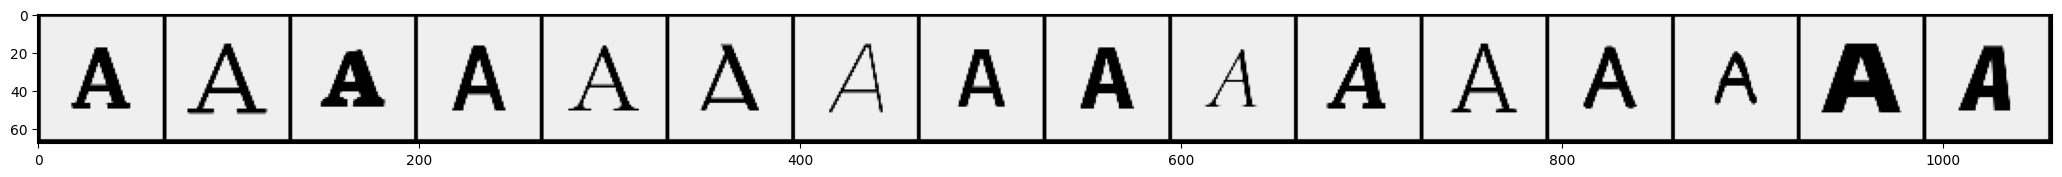


Val set: Average total loss: 0.1958, Average loss1: 0.1825, Average loss2: 0.0133
Validation loss decreased (0.014397 --> 0.013297).  Saving model ...
Starting epoch 24...


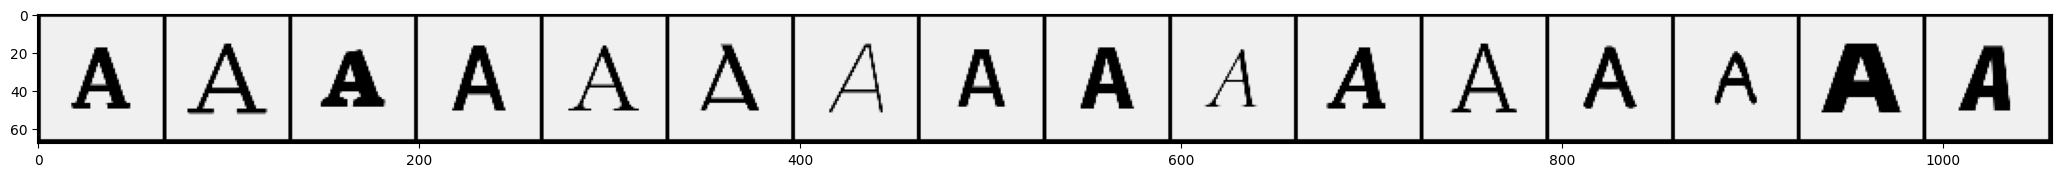


Val set: Average total loss: 0.1953, Average loss1: 0.1830, Average loss2: 0.0123
Validation loss decreased (0.013297 --> 0.012300).  Saving model ...
Starting epoch 25...


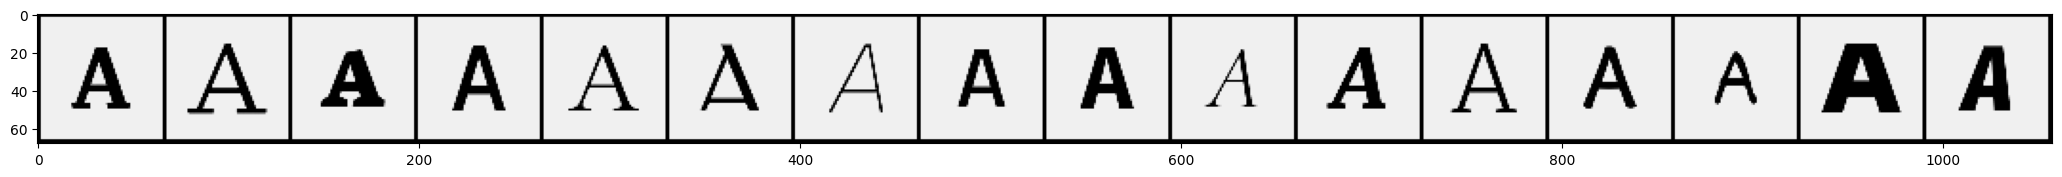


Val set: Average total loss: 0.1945, Average loss1: 0.1831, Average loss2: 0.0114
Validation loss decreased (0.012300 --> 0.011405).  Saving model ...
Starting epoch 26...


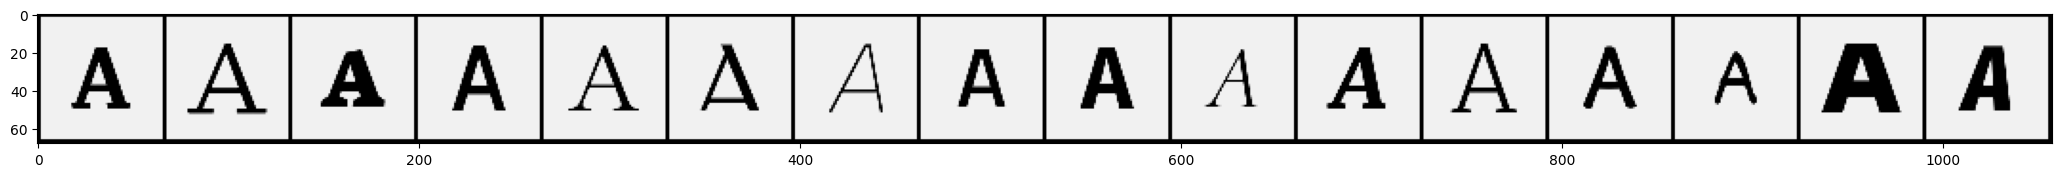


Val set: Average total loss: 0.1929, Average loss1: 0.1824, Average loss2: 0.0105
Validation loss decreased (0.011405 --> 0.010527).  Saving model ...
Starting epoch 27...


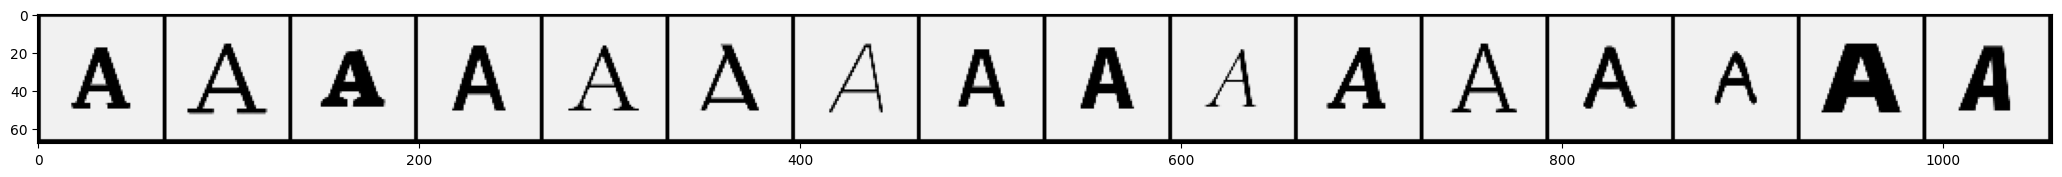


Val set: Average total loss: 0.1951, Average loss1: 0.1853, Average loss2: 0.0098
Validation loss decreased (0.010527 --> 0.009846).  Saving model ...
Starting epoch 28...


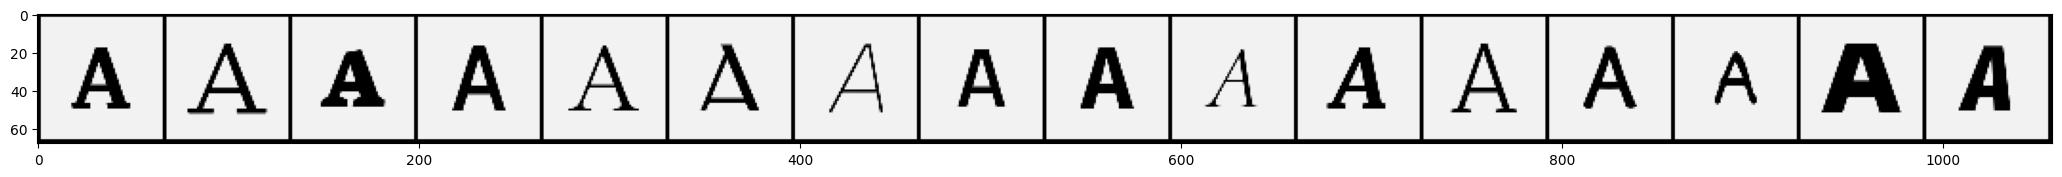


Val set: Average total loss: 0.1907, Average loss1: 0.1817, Average loss2: 0.0090
Validation loss decreased (0.009846 --> 0.009028).  Saving model ...
Starting epoch 29...


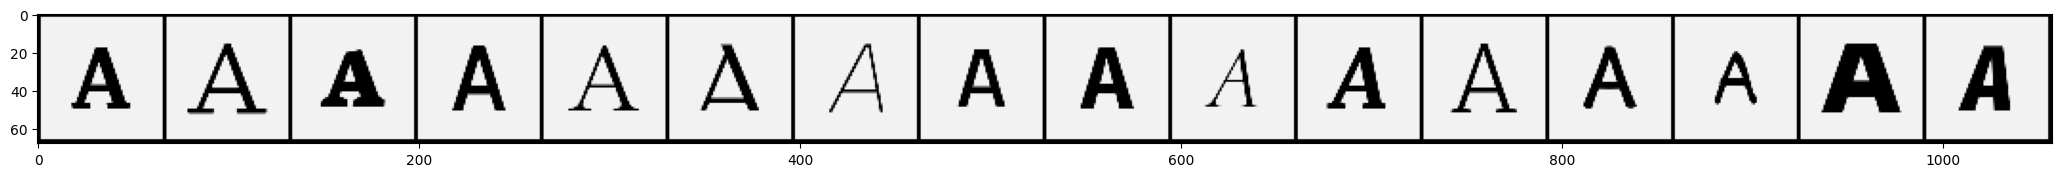


Val set: Average total loss: 0.1901, Average loss1: 0.1817, Average loss2: 0.0084
Validation loss decreased (0.009028 --> 0.008385).  Saving model ...
Starting epoch 30...


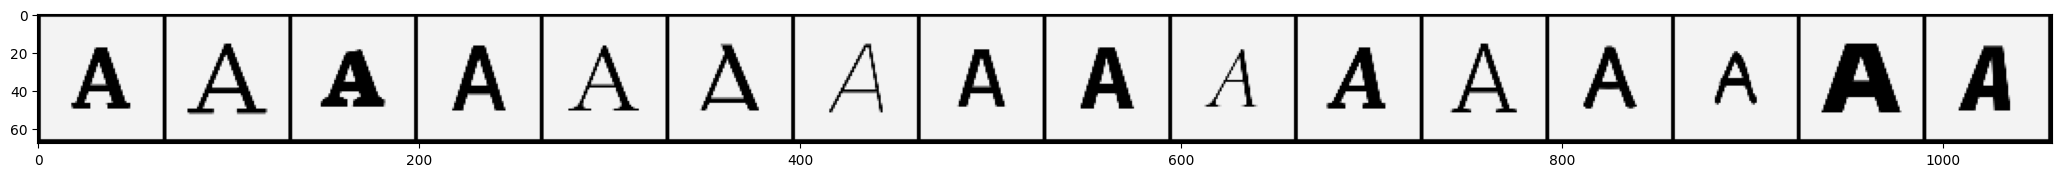


Val set: Average total loss: 0.1899, Average loss1: 0.1821, Average loss2: 0.0078
Validation loss decreased (0.008385 --> 0.007808).  Saving model ...
Starting epoch 31...


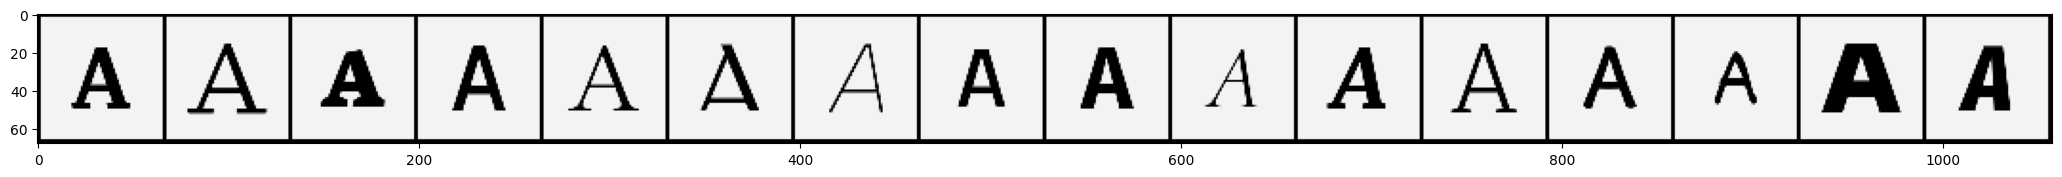


Val set: Average total loss: 0.1894, Average loss1: 0.1821, Average loss2: 0.0073
Validation loss decreased (0.007808 --> 0.007255).  Saving model ...
Starting epoch 32...


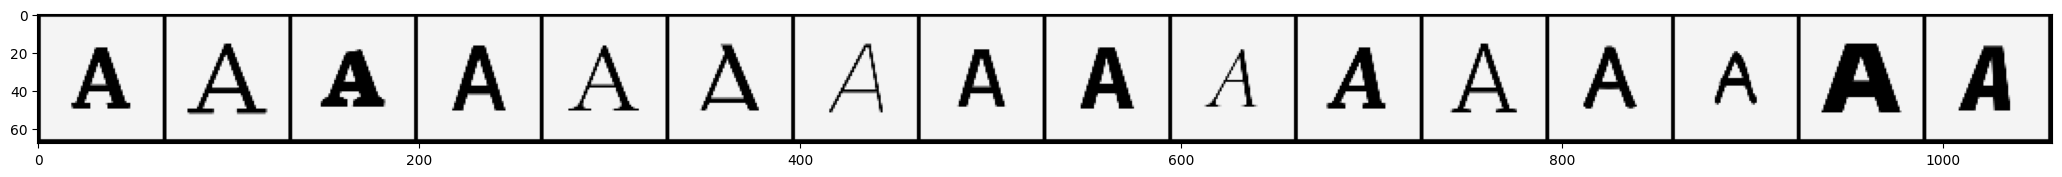


Val set: Average total loss: 0.1886, Average loss1: 0.1818, Average loss2: 0.0067
Validation loss decreased (0.007255 --> 0.006735).  Saving model ...
Starting epoch 33...


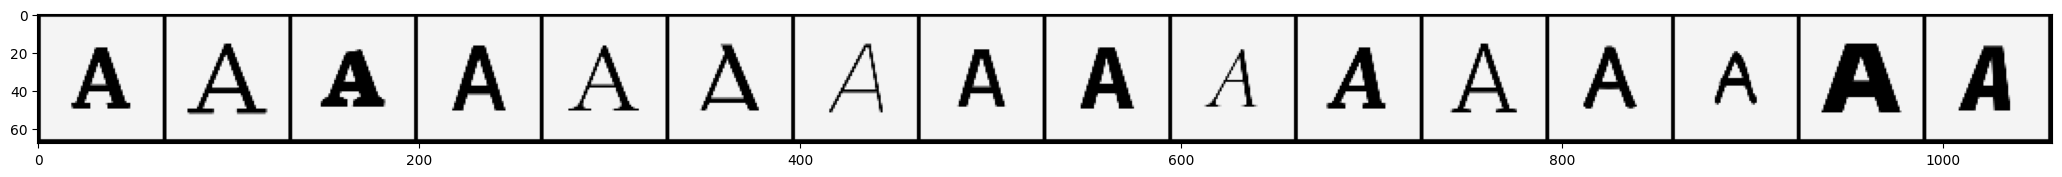


Val set: Average total loss: 0.1872, Average loss1: 0.1810, Average loss2: 0.0062
Validation loss decreased (0.006735 --> 0.006246).  Saving model ...
Starting epoch 34...


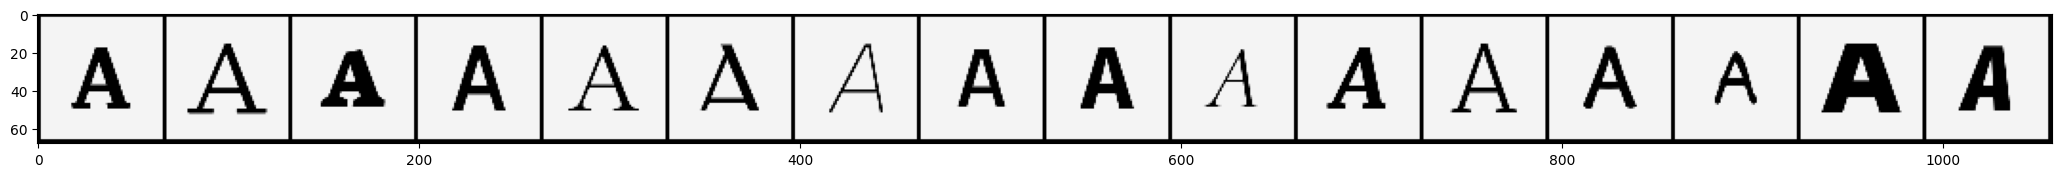


Val set: Average total loss: 0.1873, Average loss1: 0.1815, Average loss2: 0.0058
Validation loss decreased (0.006246 --> 0.005814).  Saving model ...
Starting epoch 35...


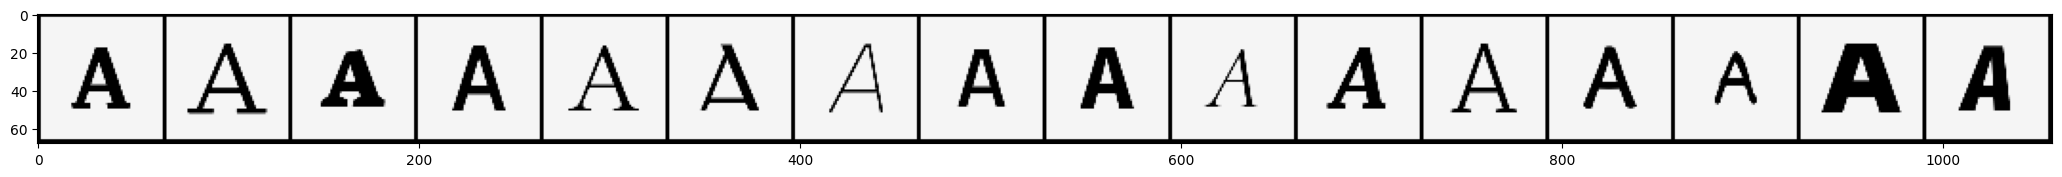


Val set: Average total loss: 0.1870, Average loss1: 0.1816, Average loss2: 0.0054
Validation loss decreased (0.005814 --> 0.005417).  Saving model ...
Starting epoch 36...


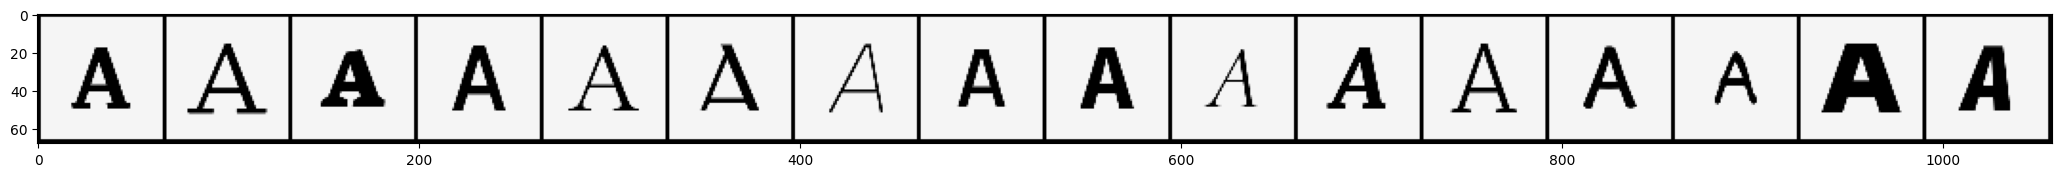


Val set: Average total loss: 0.1861, Average loss1: 0.1810, Average loss2: 0.0050
Validation loss decreased (0.005417 --> 0.005042).  Saving model ...
Starting epoch 37...


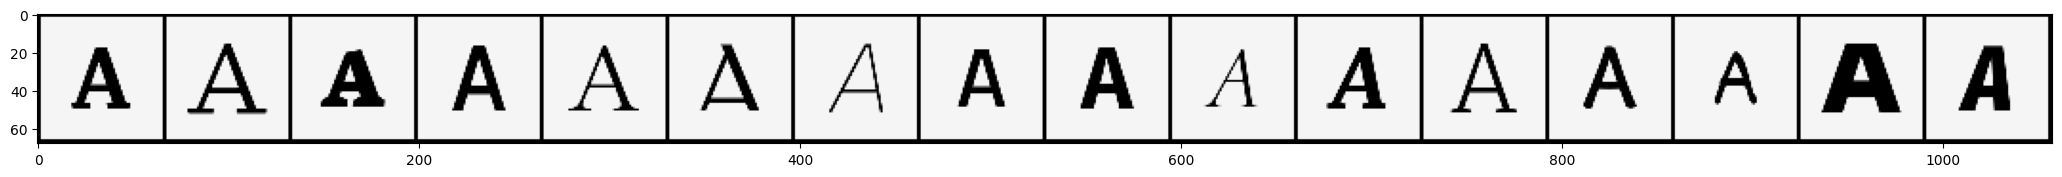


Val set: Average total loss: 0.1858, Average loss1: 0.1811, Average loss2: 0.0047
Validation loss decreased (0.005042 --> 0.004698).  Saving model ...
Starting epoch 38...


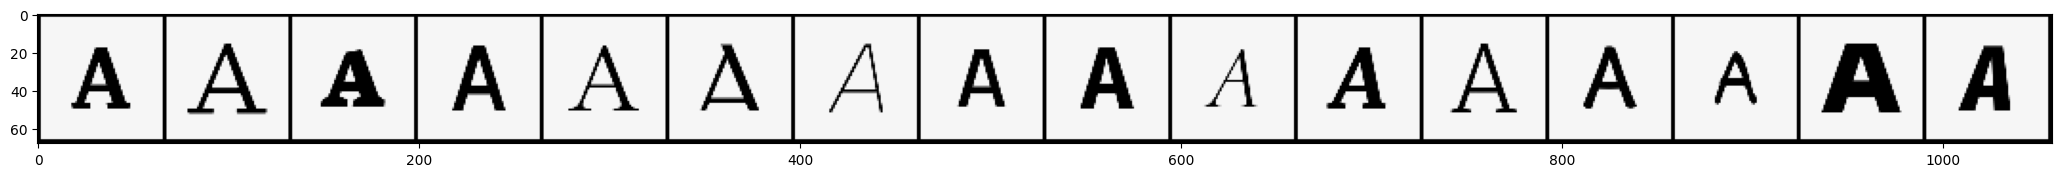


Val set: Average total loss: 0.1856, Average loss1: 0.1812, Average loss2: 0.0044
Validation loss decreased (0.004698 --> 0.004383).  Saving model ...
Starting epoch 39...


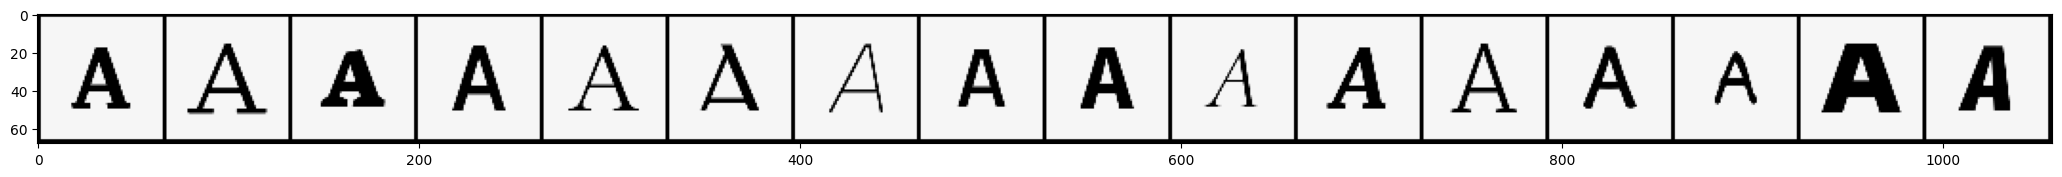


Val set: Average total loss: 0.1853, Average loss1: 0.1813, Average loss2: 0.0041
Validation loss decreased (0.004383 --> 0.004091).  Saving model ...
Starting epoch 40...


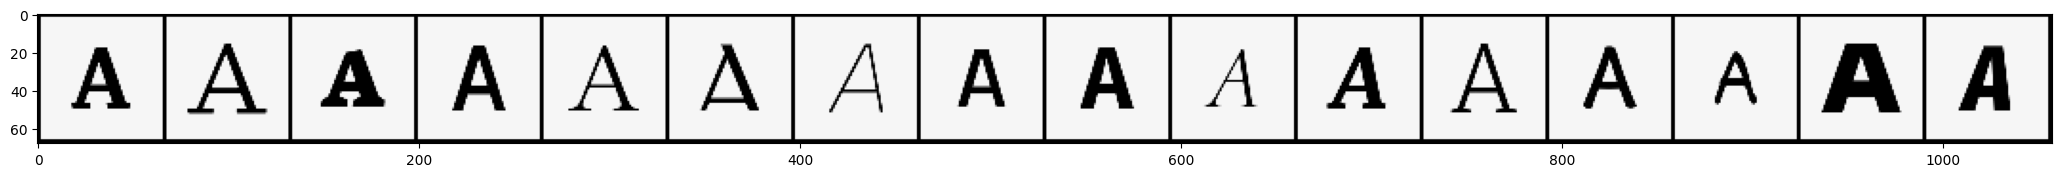


Val set: Average total loss: 0.1849, Average loss1: 0.1811, Average loss2: 0.0038
Validation loss decreased (0.004091 --> 0.003816).  Saving model ...
Starting epoch 41...


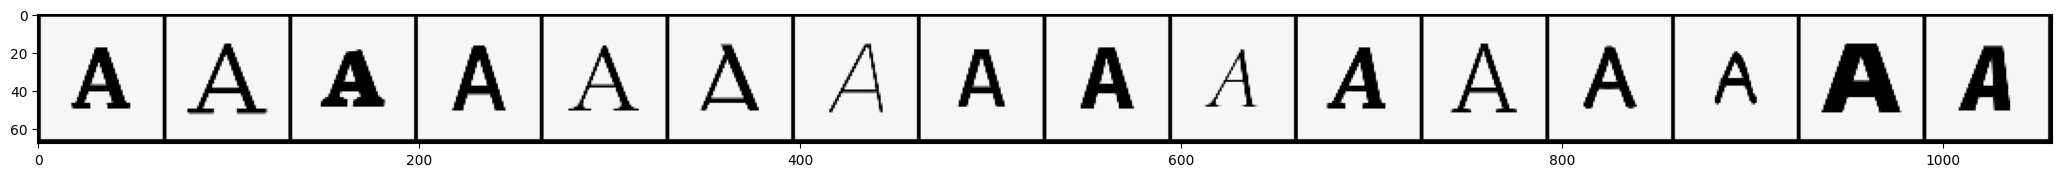


Val set: Average total loss: 0.1849, Average loss1: 0.1813, Average loss2: 0.0036
Validation loss decreased (0.003816 --> 0.003616).  Saving model ...
Starting epoch 42...


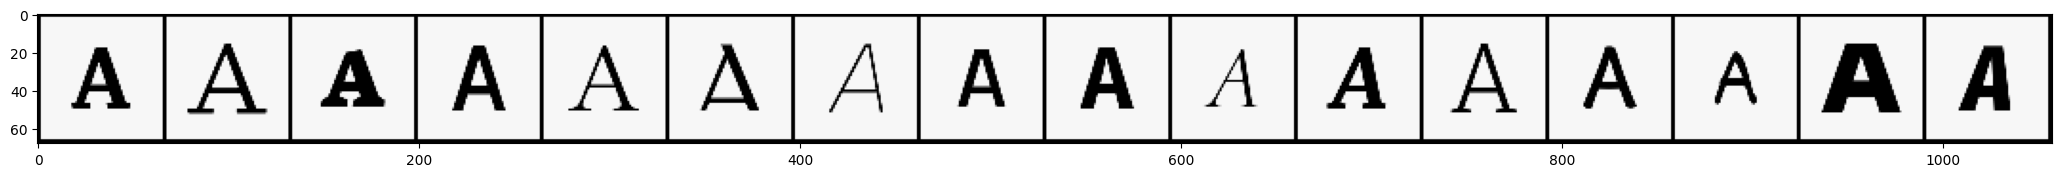


Val set: Average total loss: 0.1838, Average loss1: 0.1804, Average loss2: 0.0034
Validation loss decreased (0.003616 --> 0.003415).  Saving model ...
Starting epoch 43...


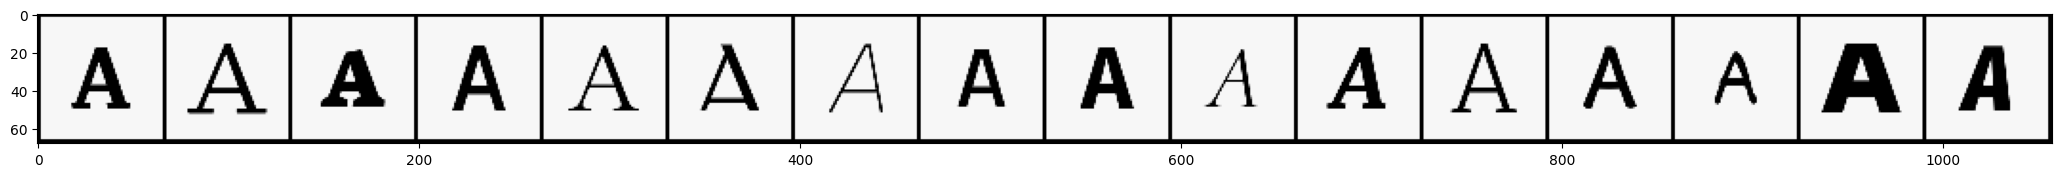


Val set: Average total loss: 0.1843, Average loss1: 0.1811, Average loss2: 0.0032
Validation loss decreased (0.003415 --> 0.003230).  Saving model ...
Starting epoch 44...


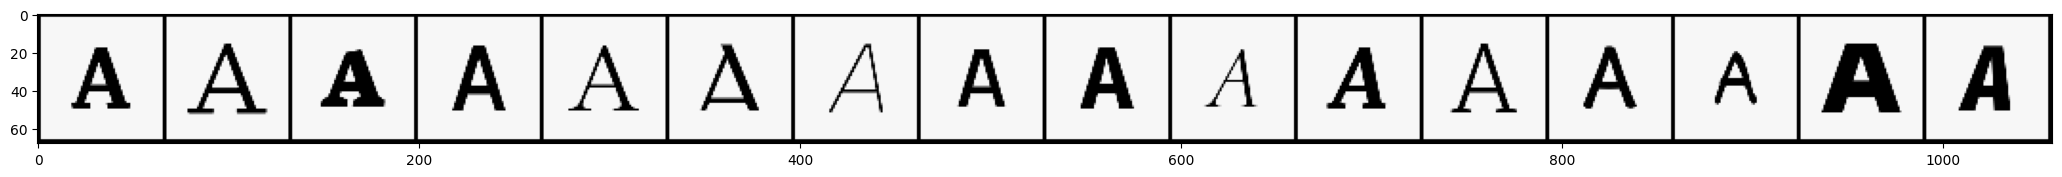


Val set: Average total loss: 0.1840, Average loss1: 0.1810, Average loss2: 0.0031
Validation loss decreased (0.003230 --> 0.003053).  Saving model ...
Starting epoch 45...


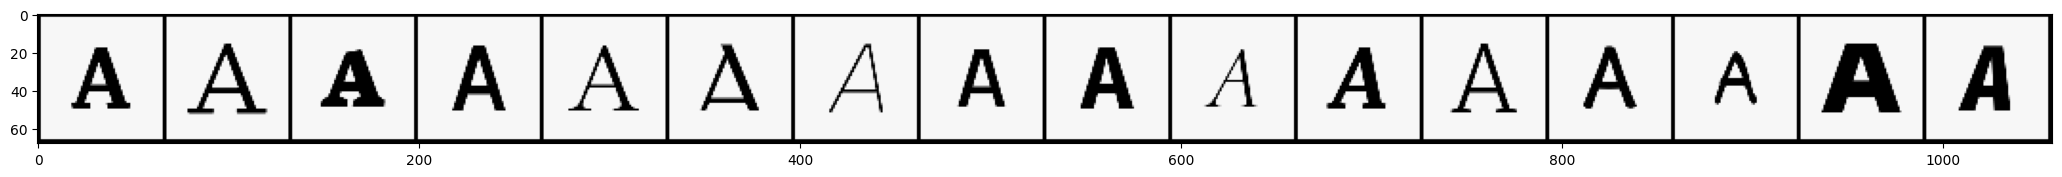


Val set: Average total loss: 0.1840, Average loss1: 0.1811, Average loss2: 0.0029
Validation loss decreased (0.003053 --> 0.002883).  Saving model ...
Starting epoch 46...


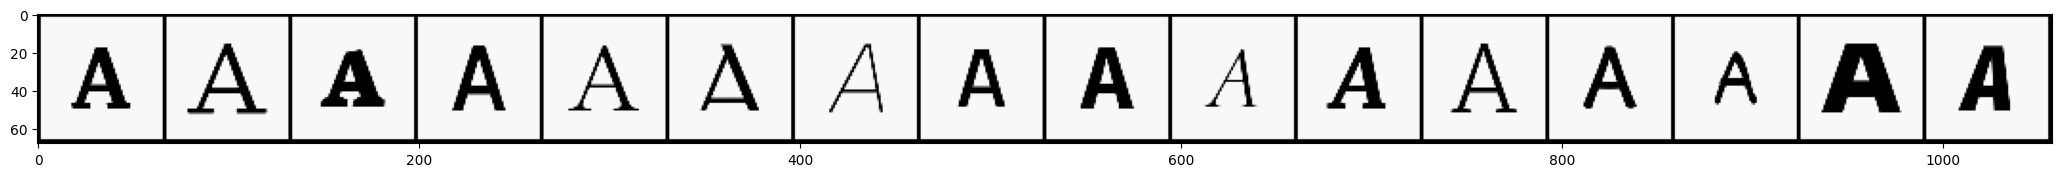


Val set: Average total loss: 0.1837, Average loss1: 0.1810, Average loss2: 0.0027
Validation loss decreased (0.002883 --> 0.002725).  Saving model ...
Starting epoch 47...


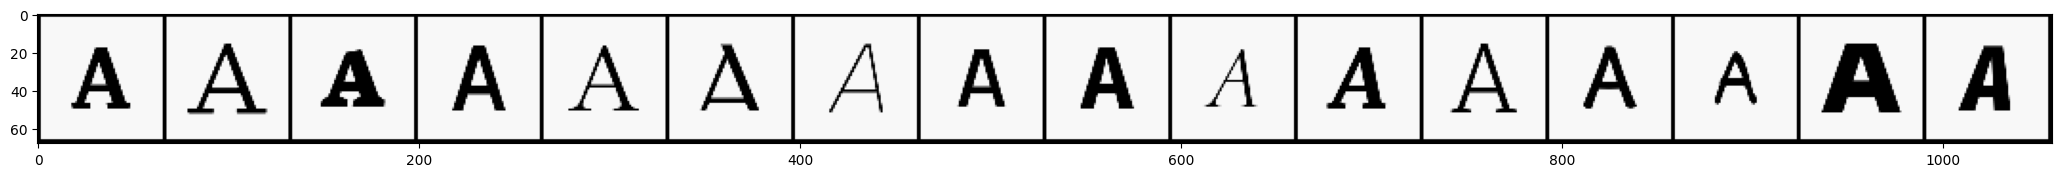


Val set: Average total loss: 0.1834, Average loss1: 0.1809, Average loss2: 0.0026
Validation loss decreased (0.002725 --> 0.002571).  Saving model ...
Starting epoch 48...


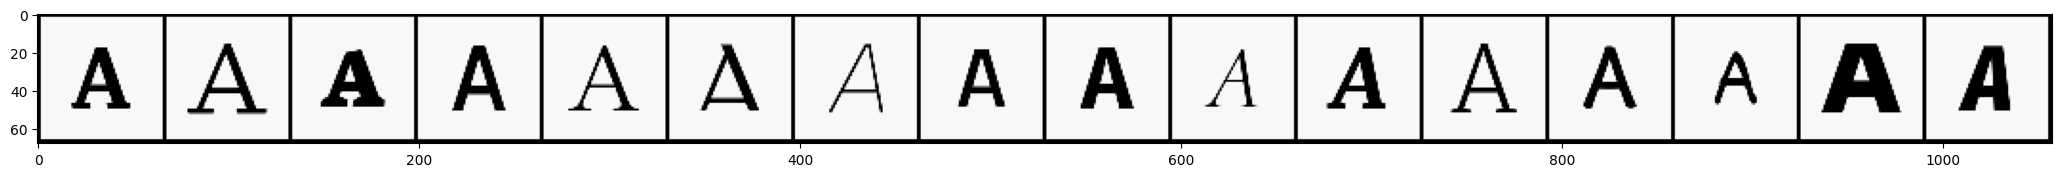


Val set: Average total loss: 0.1832, Average loss1: 0.1808, Average loss2: 0.0024
Validation loss decreased (0.002571 --> 0.002428).  Saving model ...
Starting epoch 49...


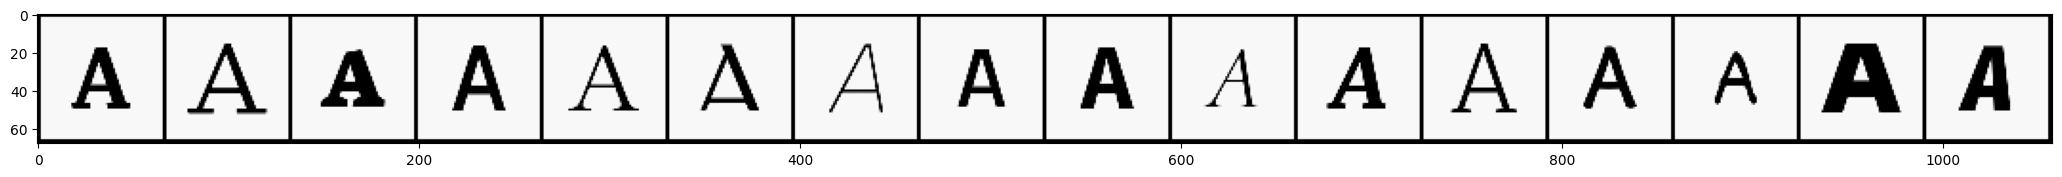


Val set: Average total loss: 0.1837, Average loss1: 0.1814, Average loss2: 0.0023
Validation loss decreased (0.002428 --> 0.002301).  Saving model ...
Starting epoch 50...


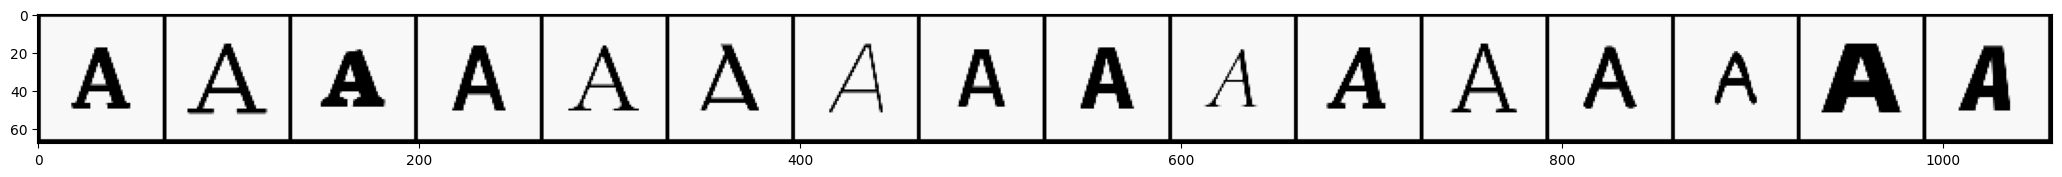


Val set: Average total loss: 0.1831, Average loss1: 0.1810, Average loss2: 0.0022
Validation loss decreased (0.002301 --> 0.002164).  Saving model ...
Starting epoch 51...


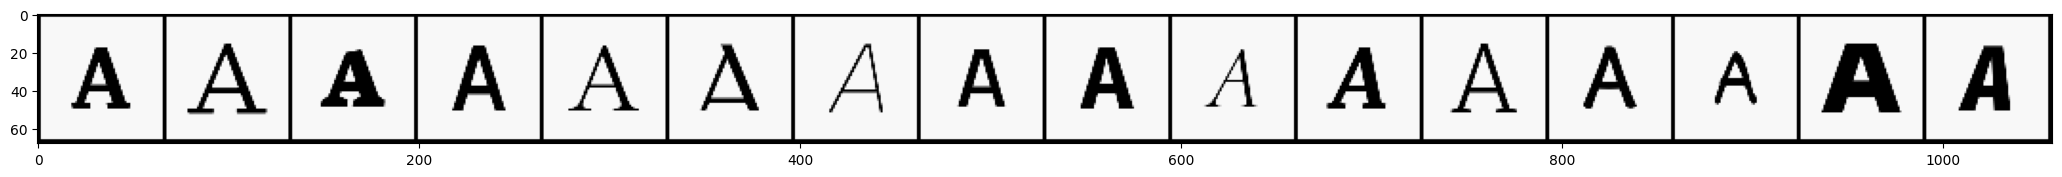


Val set: Average total loss: 0.1831, Average loss1: 0.1810, Average loss2: 0.0020
Validation loss decreased (0.002164 --> 0.002042).  Saving model ...
Starting epoch 52...


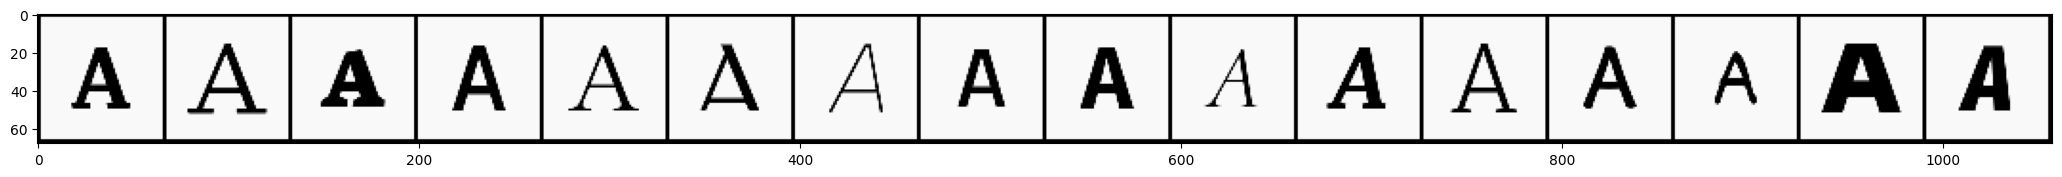


Val set: Average total loss: 0.1828, Average loss1: 0.1809, Average loss2: 0.0019
Validation loss decreased (0.002042 --> 0.001924).  Saving model ...
Starting epoch 53...


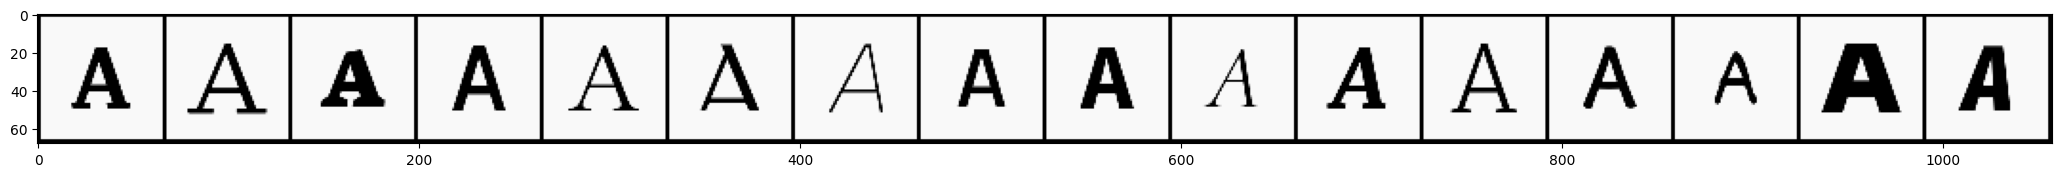


Val set: Average total loss: 0.1827, Average loss1: 0.1809, Average loss2: 0.0018
Validation loss decreased (0.001924 --> 0.001815).  Saving model ...
Starting epoch 54...


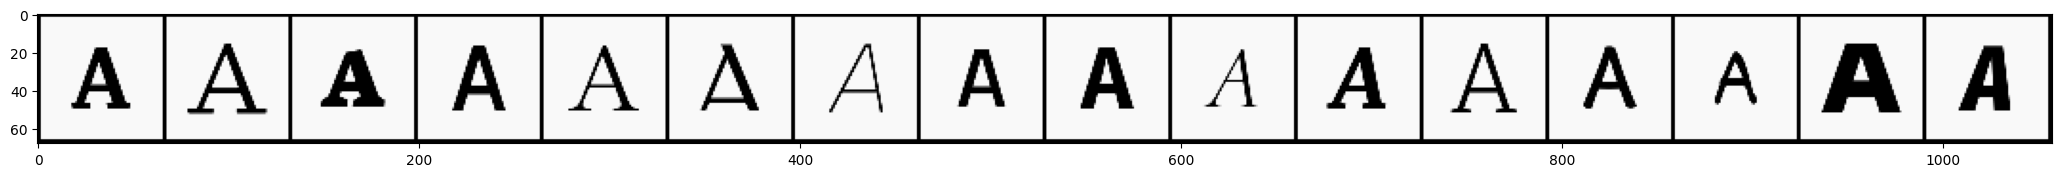


Val set: Average total loss: 0.1824, Average loss1: 0.1806, Average loss2: 0.0017
Validation loss decreased (0.001815 --> 0.001739).  Saving model ...
Starting epoch 55...


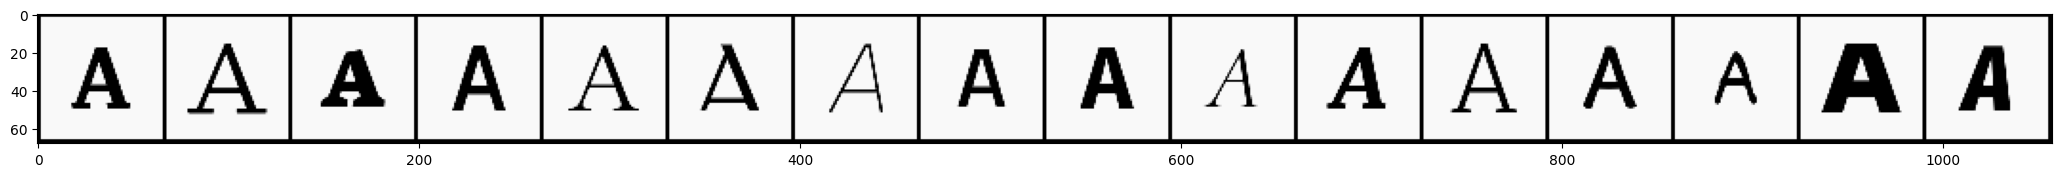


Val set: Average total loss: 0.1826, Average loss1: 0.1810, Average loss2: 0.0016
Validation loss decreased (0.001739 --> 0.001615).  Saving model ...
Starting epoch 56...


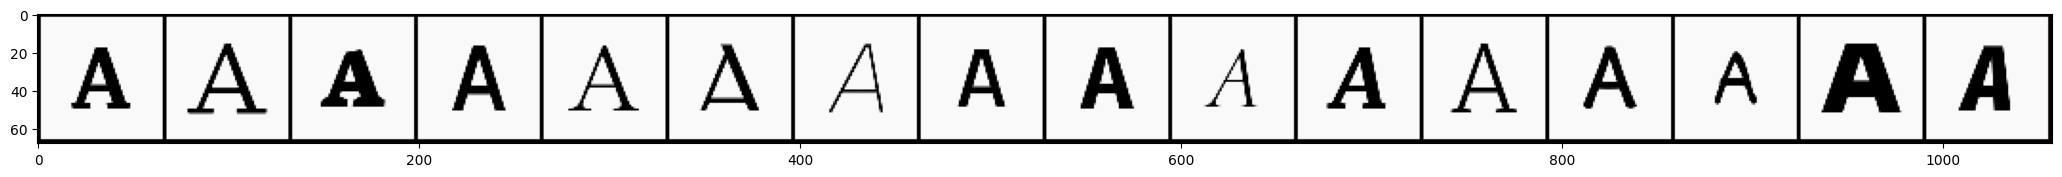


Val set: Average total loss: 0.1826, Average loss1: 0.1811, Average loss2: 0.0015
Validation loss decreased (0.001615 --> 0.001524).  Saving model ...
Starting epoch 57...


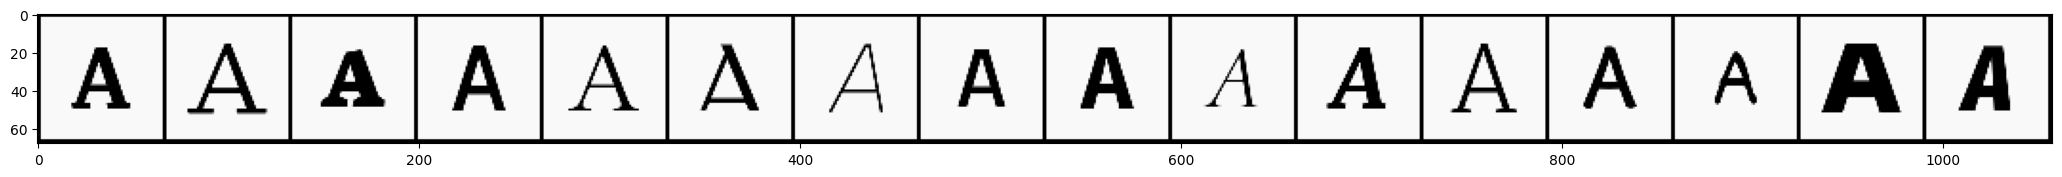


Val set: Average total loss: 0.1824, Average loss1: 0.1810, Average loss2: 0.0014
Validation loss decreased (0.001524 --> 0.001434).  Saving model ...
Starting epoch 58...


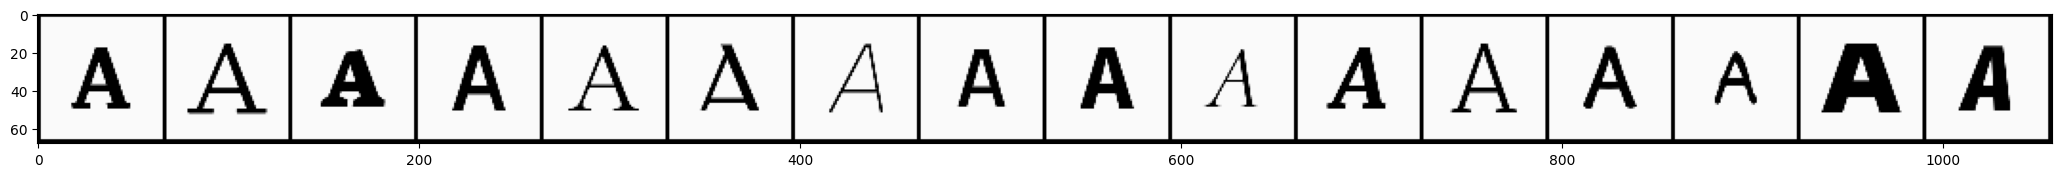


Val set: Average total loss: 0.1824, Average loss1: 0.1810, Average loss2: 0.0014
Validation loss decreased (0.001434 --> 0.001356).  Saving model ...
Starting epoch 59...


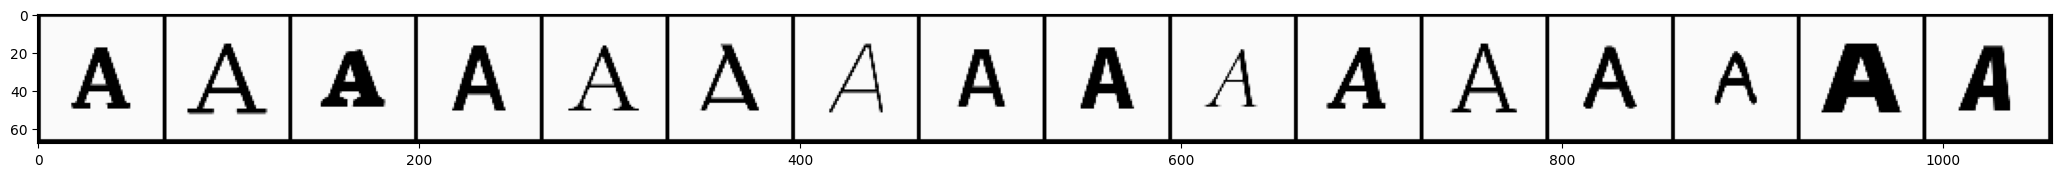


Val set: Average total loss: 0.1824, Average loss1: 0.1811, Average loss2: 0.0013
Validation loss decreased (0.001356 --> 0.001294).  Saving model ...
Starting epoch 60...


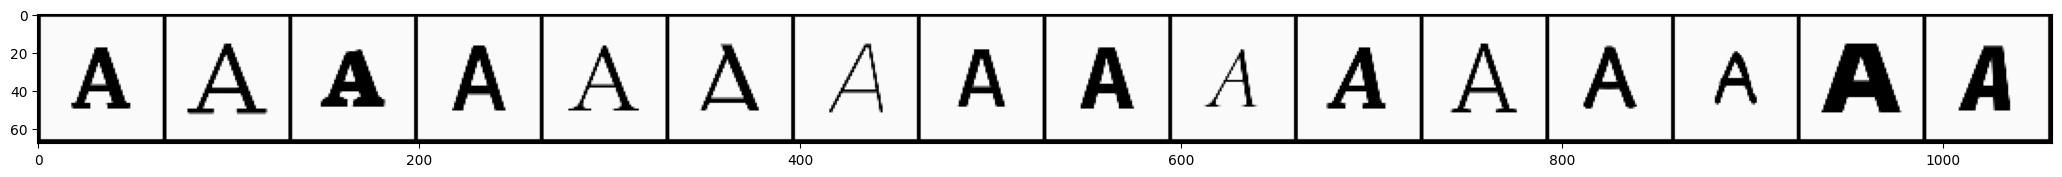


Val set: Average total loss: 0.1824, Average loss1: 0.1812, Average loss2: 0.0012
Validation loss decreased (0.001294 --> 0.001202).  Saving model ...
Starting epoch 61...


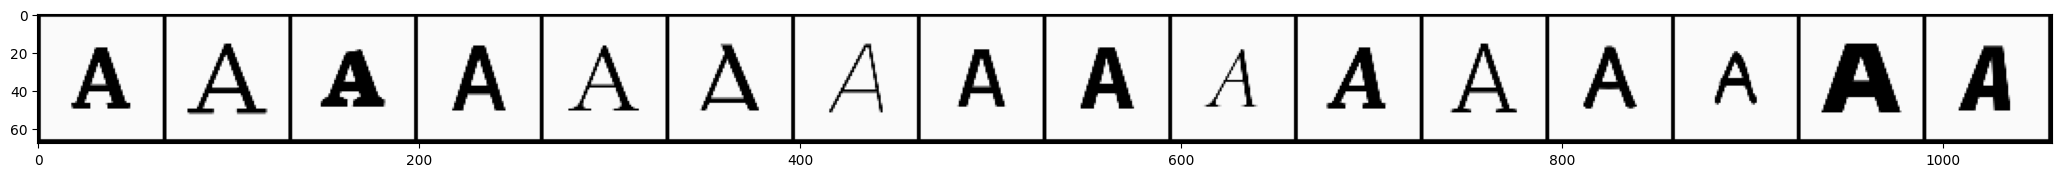


Val set: Average total loss: 0.1826, Average loss1: 0.1814, Average loss2: 0.0012
Validation loss decreased (0.001202 --> 0.001153).  Saving model ...
Starting epoch 62...


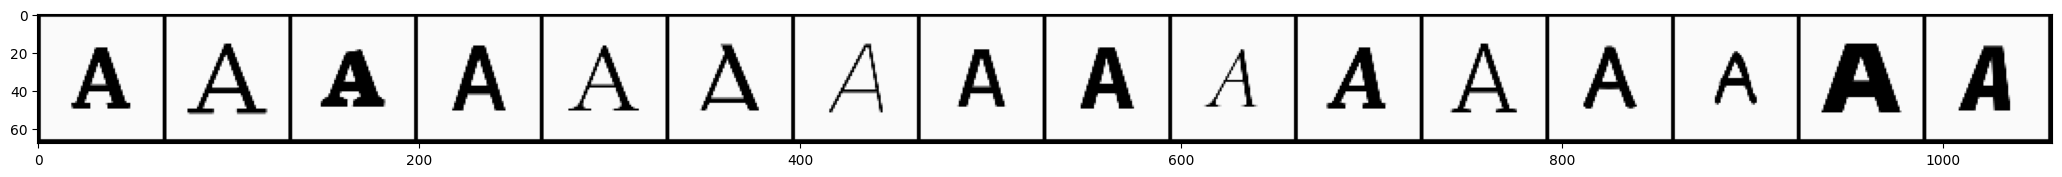


Val set: Average total loss: 0.1820, Average loss1: 0.1809, Average loss2: 0.0011
Validation loss decreased (0.001153 --> 0.001091).  Saving model ...
Starting epoch 63...


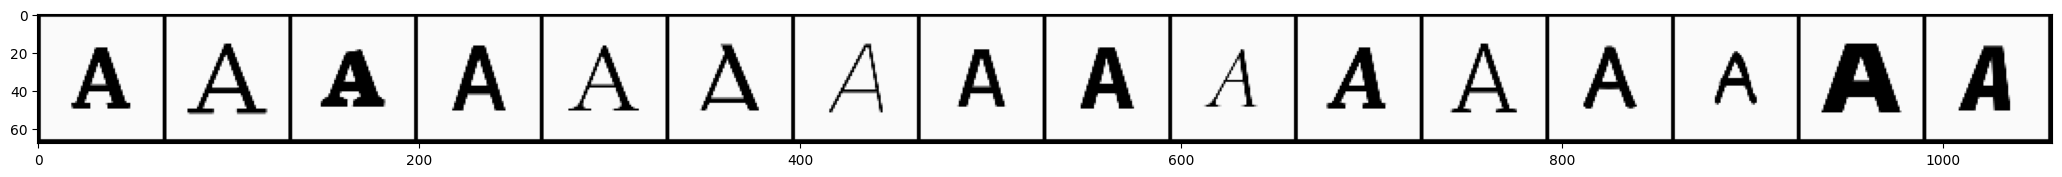


Val set: Average total loss: 0.1819, Average loss1: 0.1808, Average loss2: 0.0010
Validation loss decreased (0.001091 --> 0.001037).  Saving model ...
Starting epoch 64...


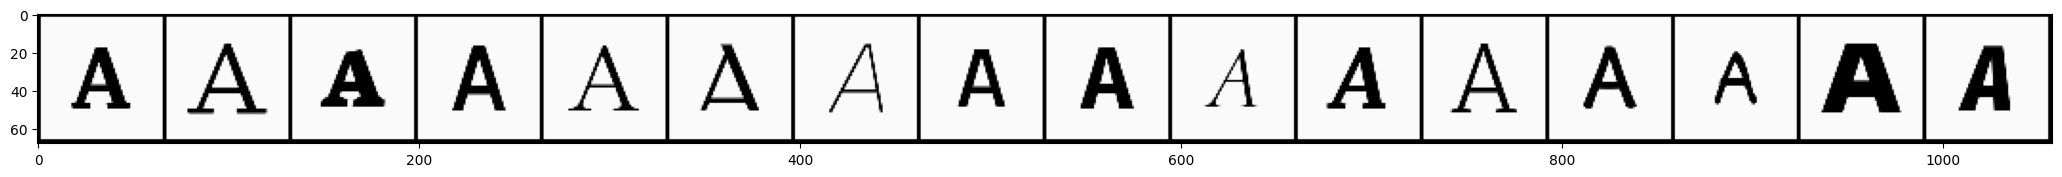


Val set: Average total loss: 0.1808, Average loss1: 0.1798, Average loss2: 0.0010
Validation loss decreased (0.001037 --> 0.000996).  Saving model ...
Starting epoch 65...


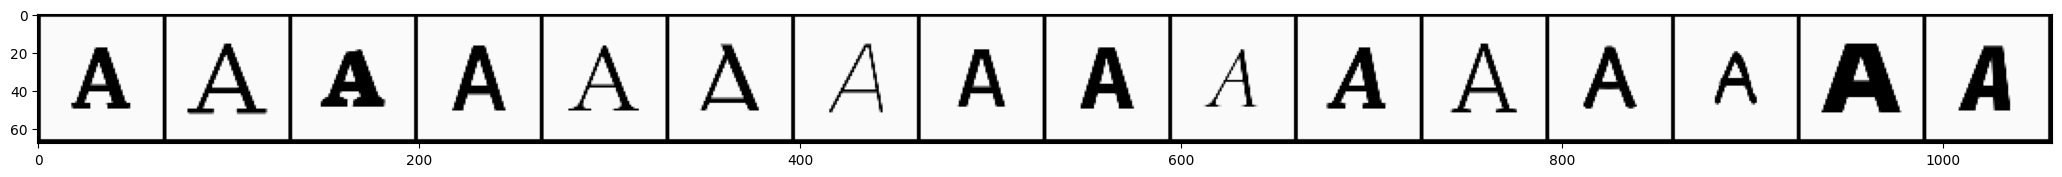


Val set: Average total loss: 0.1816, Average loss1: 0.1807, Average loss2: 0.0009
Validation loss decreased (0.000996 --> 0.000938).  Saving model ...
Starting epoch 66...


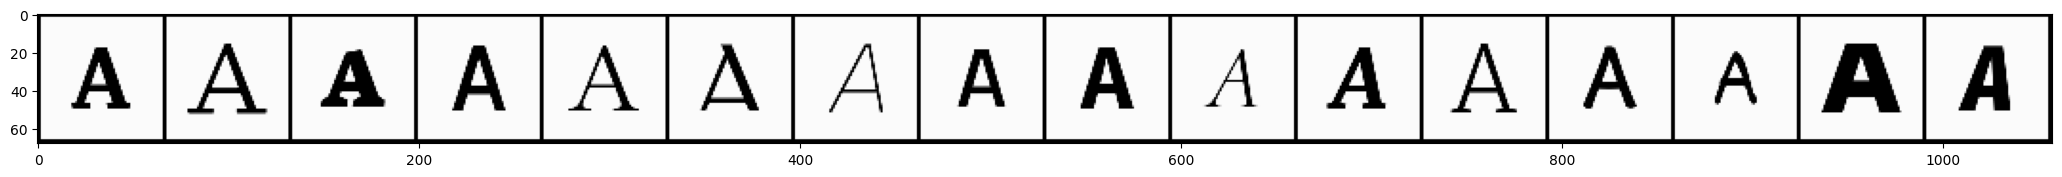


Val set: Average total loss: 0.1814, Average loss1: 0.1806, Average loss2: 0.0009
Validation loss decreased (0.000938 --> 0.000892).  Saving model ...
Starting epoch 67...


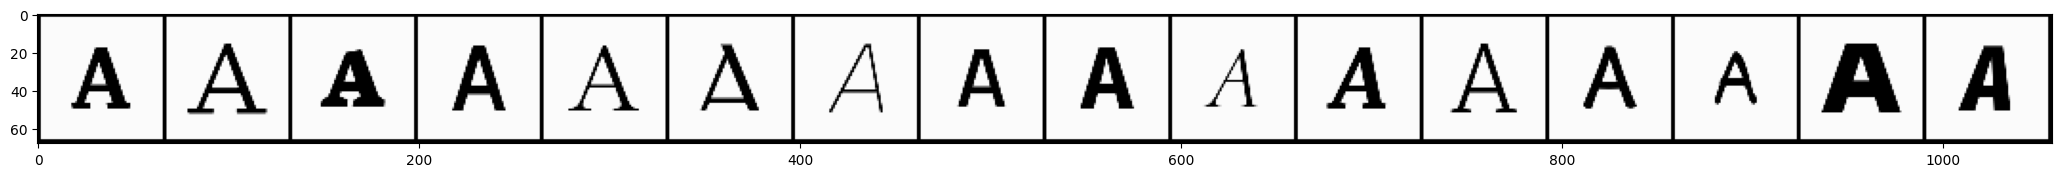


Val set: Average total loss: 0.1815, Average loss1: 0.1807, Average loss2: 0.0008
Validation loss decreased (0.000892 --> 0.000847).  Saving model ...
Starting epoch 68...


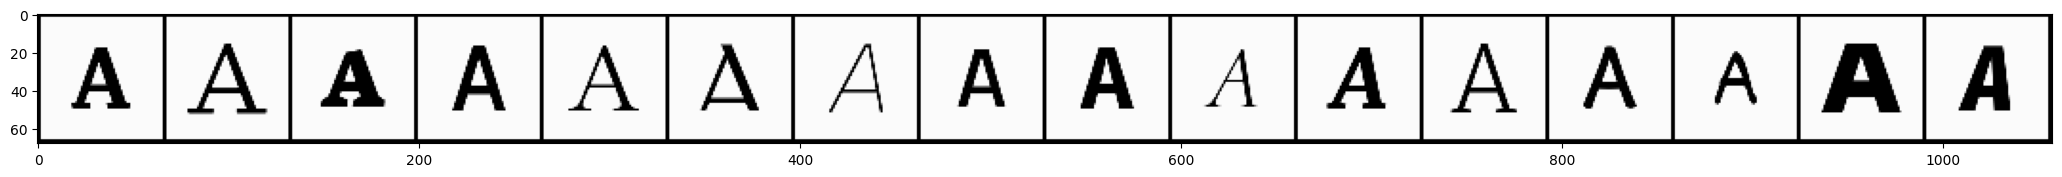


Val set: Average total loss: 0.1814, Average loss1: 0.1806, Average loss2: 0.0008
Validation loss decreased (0.000847 --> 0.000814).  Saving model ...
Starting epoch 69...


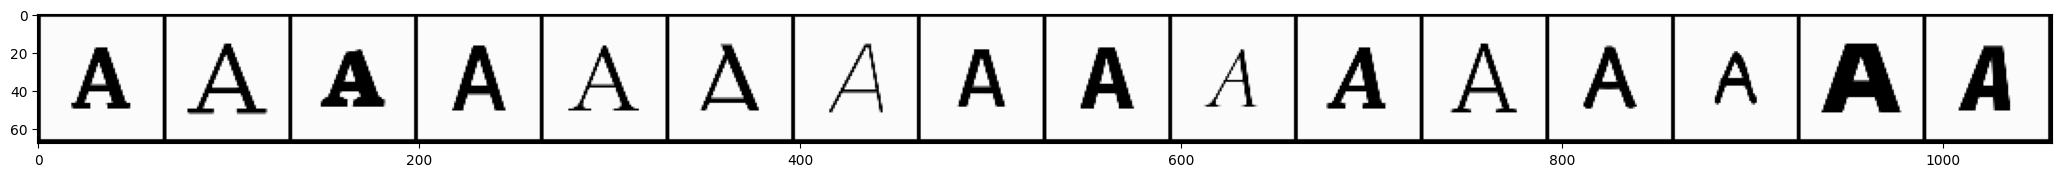


Val set: Average total loss: 0.1818, Average loss1: 0.1810, Average loss2: 0.0008
Validation loss decreased (0.000814 --> 0.000766).  Saving model ...
Starting epoch 70...


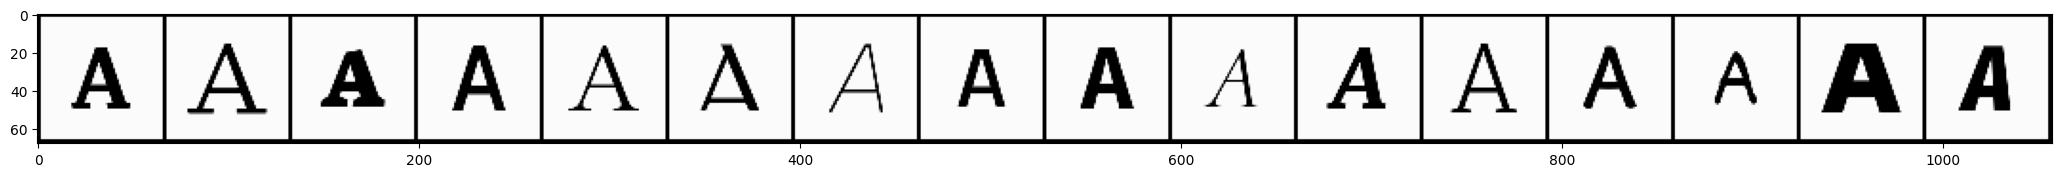


Val set: Average total loss: 0.1819, Average loss1: 0.1812, Average loss2: 0.0007
Validation loss decreased (0.000766 --> 0.000727).  Saving model ...
Starting epoch 71...


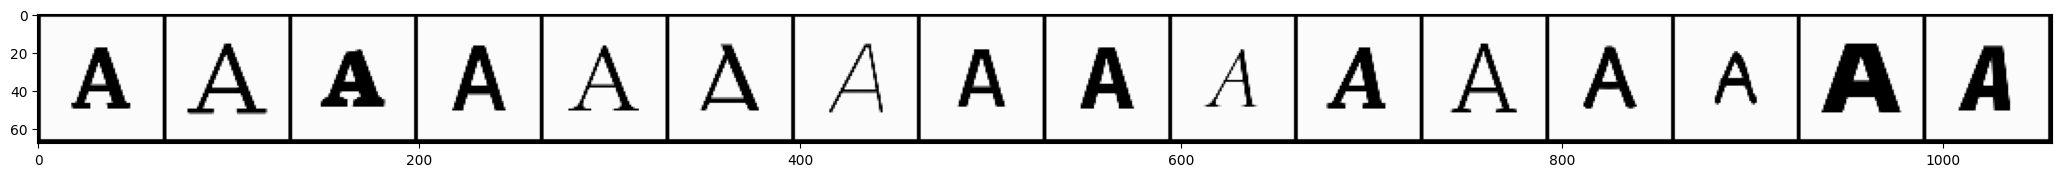


Val set: Average total loss: 0.1817, Average loss1: 0.1810, Average loss2: 0.0007
Validation loss decreased (0.000727 --> 0.000688).  Saving model ...
Starting epoch 72...


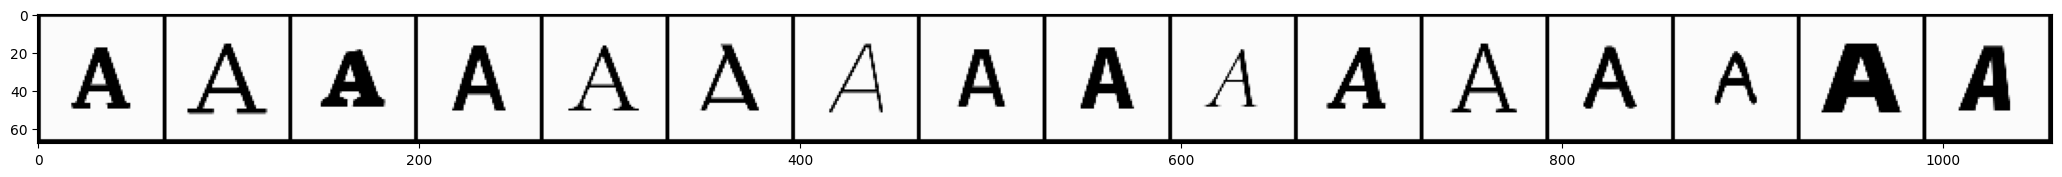


Val set: Average total loss: 0.1814, Average loss1: 0.1807, Average loss2: 0.0007
Validation loss decreased (0.000688 --> 0.000652).  Saving model ...
Starting epoch 73...


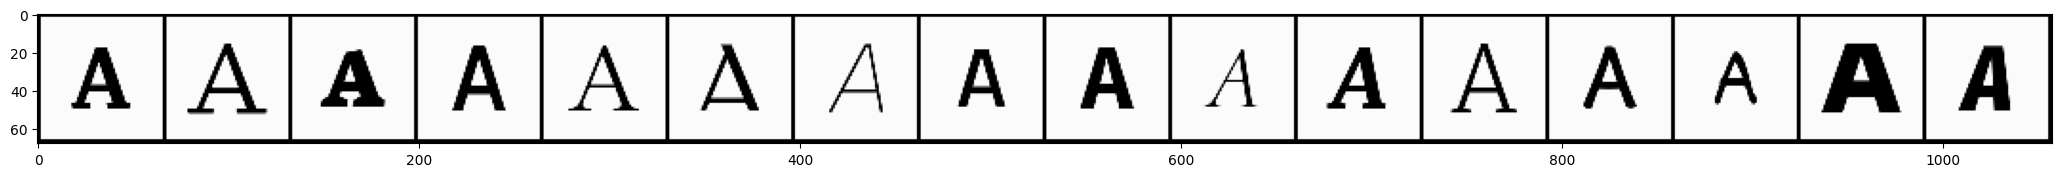


Val set: Average total loss: 0.1815, Average loss1: 0.1809, Average loss2: 0.0006
Validation loss decreased (0.000652 --> 0.000619).  Saving model ...
Starting epoch 74...


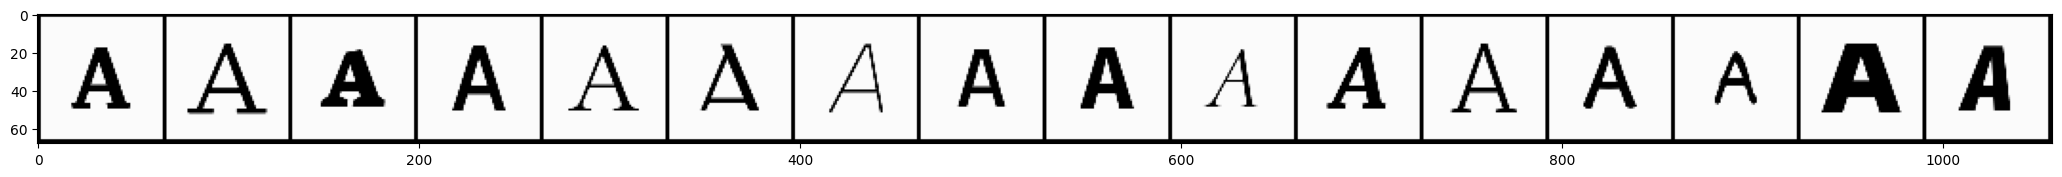


Val set: Average total loss: 0.1823, Average loss1: 0.1818, Average loss2: 0.0006
Validation loss decreased (0.000619 --> 0.000597).  Saving model ...
Starting epoch 75...


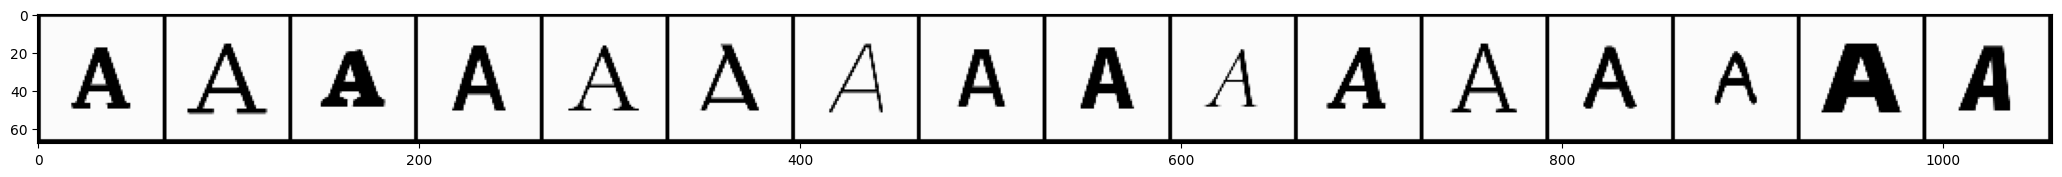


Val set: Average total loss: 0.1809, Average loss1: 0.1803, Average loss2: 0.0006
Validation loss decreased (0.000597 --> 0.000555).  Saving model ...
Starting epoch 76...


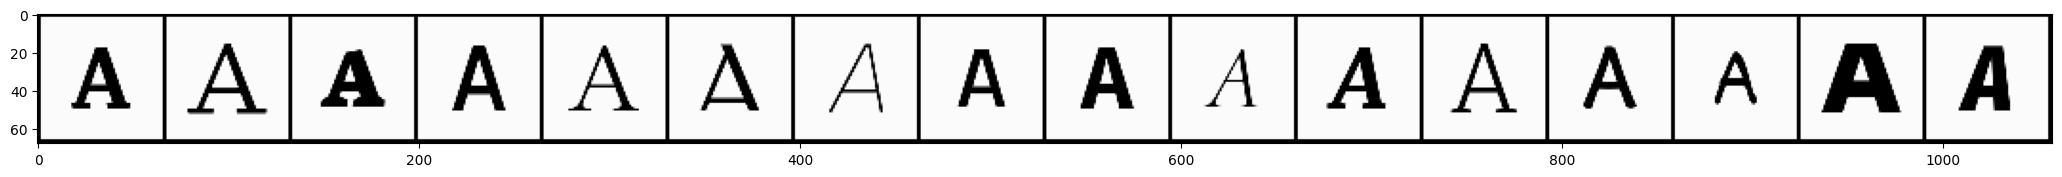


Val set: Average total loss: 0.1810, Average loss1: 0.1805, Average loss2: 0.0005
Validation loss decreased (0.000555 --> 0.000525).  Saving model ...
Starting epoch 77...


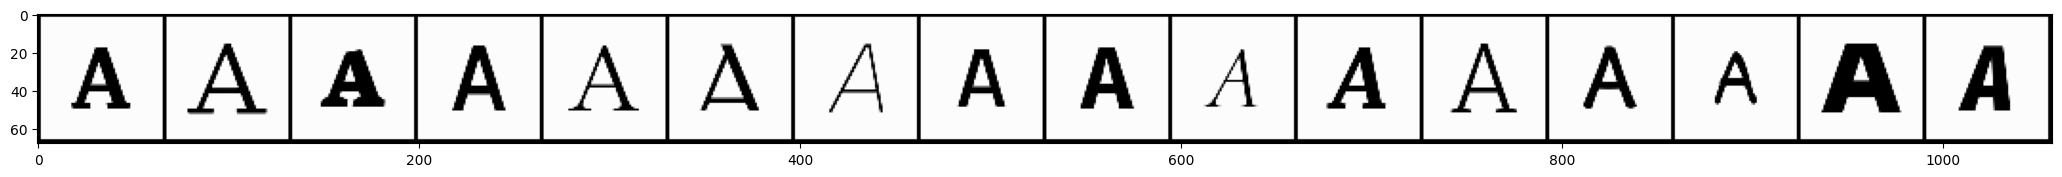


Val set: Average total loss: 0.1813, Average loss1: 0.1808, Average loss2: 0.0005
Validation loss decreased (0.000525 --> 0.000497).  Saving model ...
Starting epoch 78...


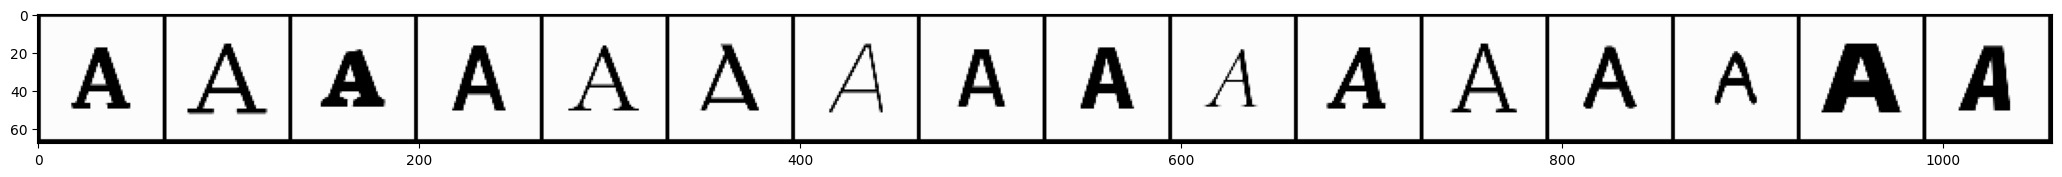


Val set: Average total loss: 0.1812, Average loss1: 0.1807, Average loss2: 0.0005
Validation loss decreased (0.000497 --> 0.000475).  Saving model ...
Starting epoch 79...


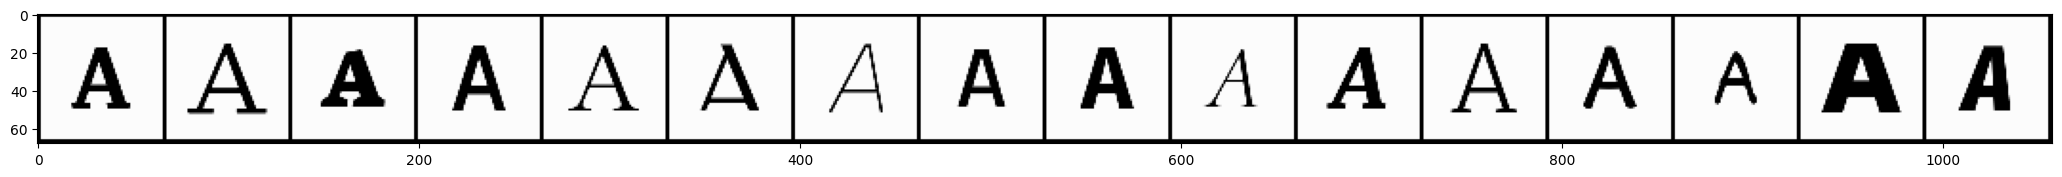


Val set: Average total loss: 0.1812, Average loss1: 0.1808, Average loss2: 0.0004
Validation loss decreased (0.000475 --> 0.000448).  Saving model ...
Starting epoch 80...


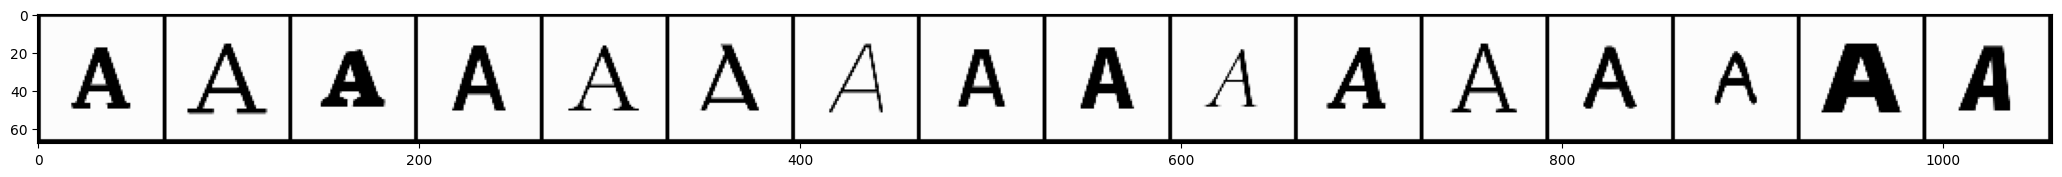


Val set: Average total loss: 0.1827, Average loss1: 0.1822, Average loss2: 0.0005
EarlyStopping counter: 1 out of 10
Starting epoch 81...


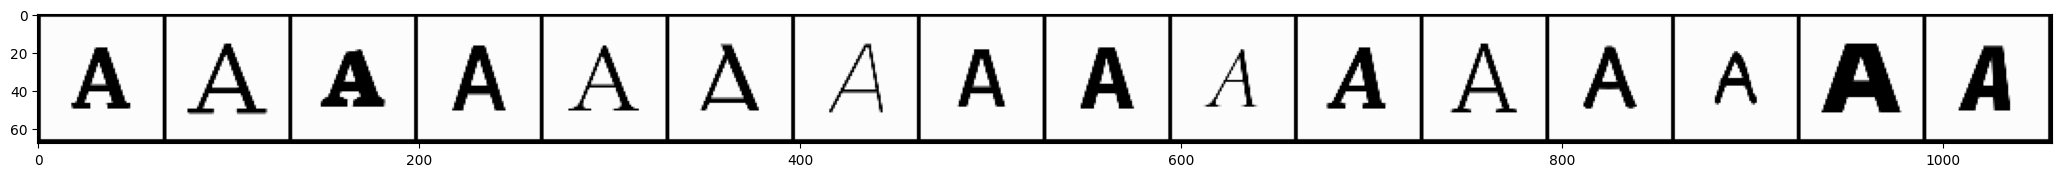


Val set: Average total loss: 0.1817, Average loss1: 0.1813, Average loss2: 0.0004
Validation loss decreased (0.000448 --> 0.000408).  Saving model ...
Starting epoch 82...


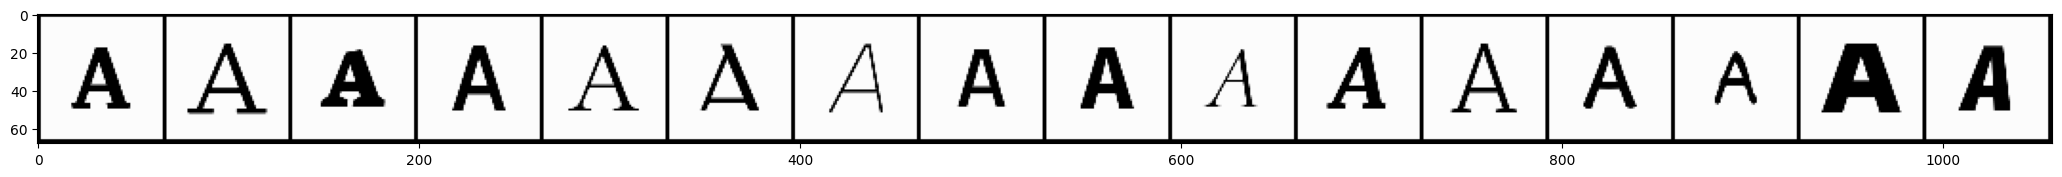


Val set: Average total loss: 0.1810, Average loss1: 0.1806, Average loss2: 0.0004
Validation loss decreased (0.000408 --> 0.000385).  Saving model ...
Starting epoch 83...


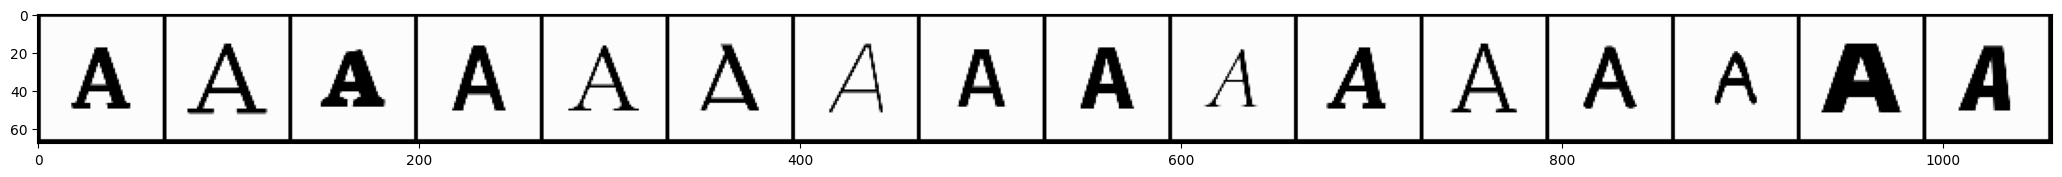


Val set: Average total loss: 0.1807, Average loss1: 0.1804, Average loss2: 0.0004
Validation loss decreased (0.000385 --> 0.000369).  Saving model ...
Starting epoch 84...


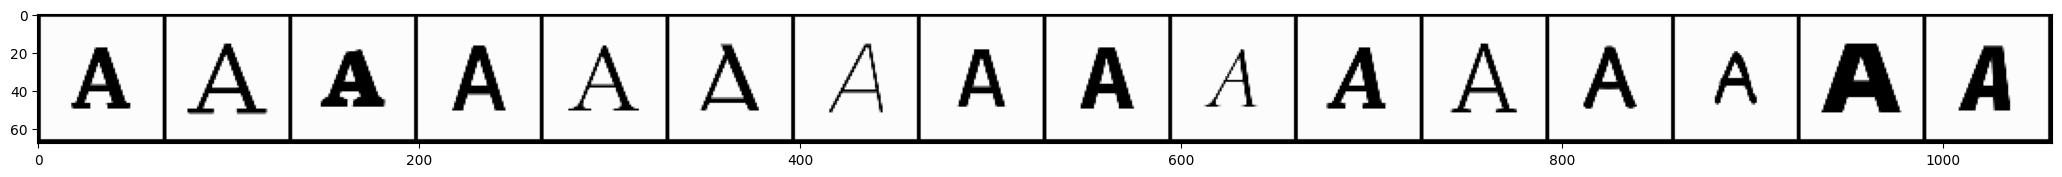


Val set: Average total loss: 0.1804, Average loss1: 0.1800, Average loss2: 0.0004
Validation loss decreased (0.000369 --> 0.000354).  Saving model ...
Starting epoch 85...


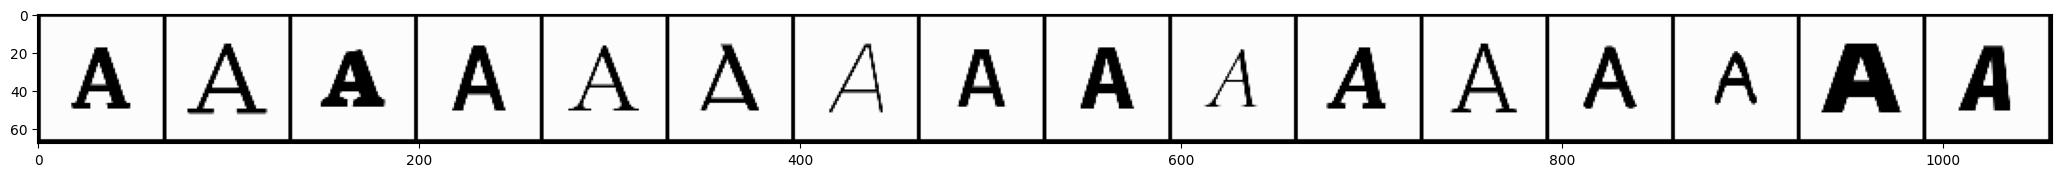


Val set: Average total loss: 0.1803, Average loss1: 0.1800, Average loss2: 0.0003
Validation loss decreased (0.000354 --> 0.000342).  Saving model ...
Starting epoch 86...


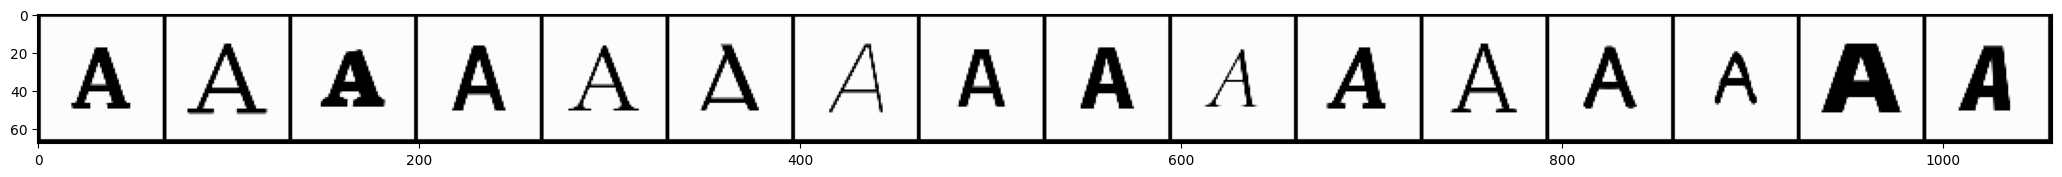


Val set: Average total loss: 0.1811, Average loss1: 0.1807, Average loss2: 0.0003
Validation loss decreased (0.000342 --> 0.000319).  Saving model ...
Starting epoch 87...


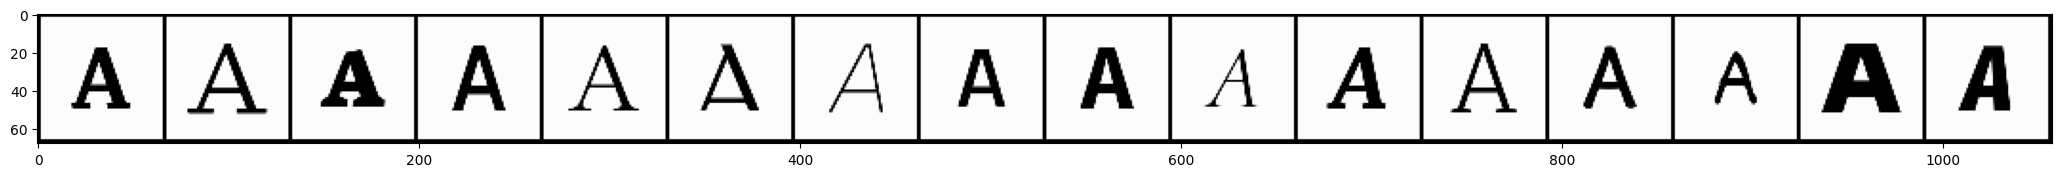


Val set: Average total loss: 0.1810, Average loss1: 0.1807, Average loss2: 0.0003
Validation loss decreased (0.000319 --> 0.000304).  Saving model ...
Starting epoch 88...


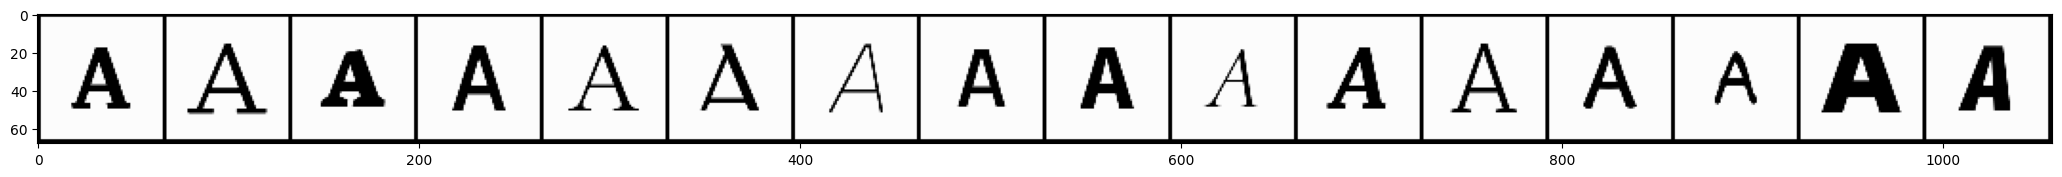


Val set: Average total loss: 0.1808, Average loss1: 0.1805, Average loss2: 0.0003
Validation loss decreased (0.000304 --> 0.000290).  Saving model ...
Starting epoch 89...


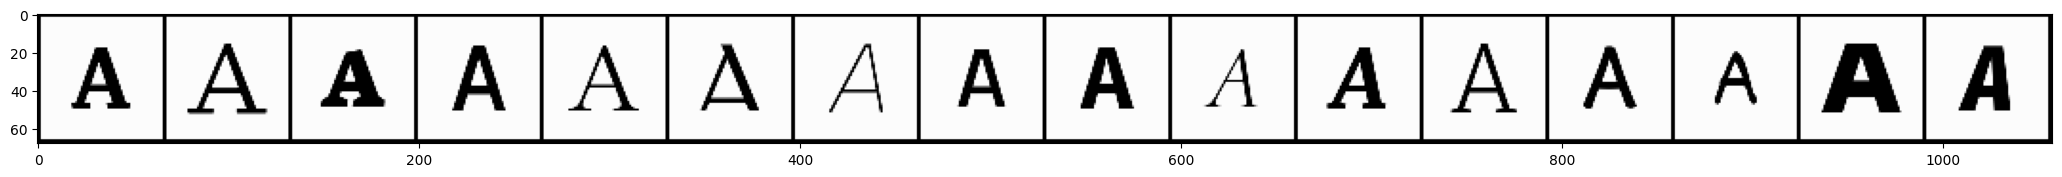


Val set: Average total loss: 0.1806, Average loss1: 0.1803, Average loss2: 0.0003
Validation loss decreased (0.000290 --> 0.000277).  Saving model ...
Starting epoch 90...


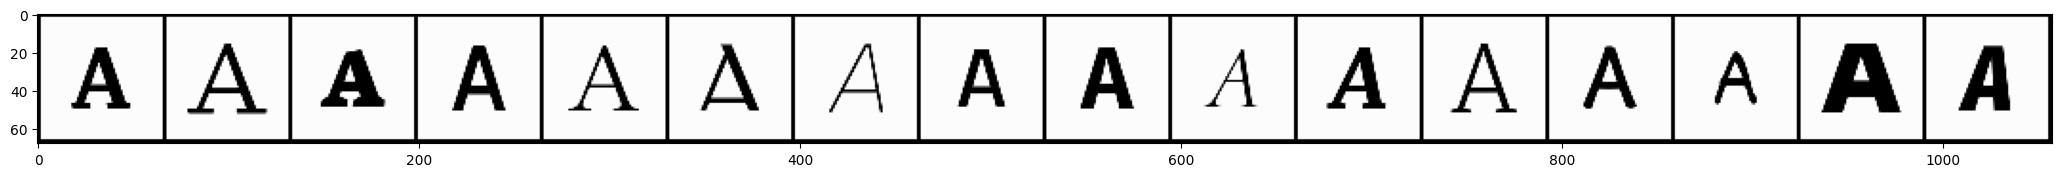


Val set: Average total loss: 0.1803, Average loss1: 0.1800, Average loss2: 0.0003
Validation loss decreased (0.000277 --> 0.000271).  Saving model ...
Starting epoch 91...


In [15]:
epochs = 10000
for epoch in range(epochs):
    print('Starting epoch {}...'.format(epoch+1))
    train(epoch)
    val_loss2 = val(epoch)
#     val_loss1, val_loss2 = val(epoch)
    earlystopping(val_loss2, unet)
#     earlystopping(val_loss1, val_loss2, unet)
    if earlystopping.early_stop: #ストップフラグがTrueの場合、breakでforループを抜ける
            print("Early Stopping!")
            break
    scheduler.step()
    # for batch_idx, (image, target) in enumerate(train_loader):
    #     if target[63].item() != 0:
    #         break
    #     unet.train()
    #     optimizer.zero_grad()
    #     image, target = Variable(image).to(device), Variable(target.to(device))
    #     generated = unet(image)
    #     output = model(generated)
    #     loss1 = F.nll_loss(output, target)
    #     loss2 = F.mse_loss(generated, image)
    #     loss = loss2
    #     loss.backward()
    #     optimizer.step()
    #     if batch_idx % 10 == 0:
    #         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    #             epoch + 1, batch_idx * len(image), len(image) * len(train_loader),
    #             100. * batch_idx / len(train_loader), loss.item()))
    #         print("loss1:{}  loss2:{}".format(loss1, loss2))
    #     if batch_idx == 38 and epoch == 0:
    #         # print(image)
    #         # print(generated)
    #         generated = (generated + 1) / 2
    #         grid = make_grid(image.data.cpu(), nrow=16, normalize=False).permute(1,2,0).numpy()
    #         fig, ax = plt.subplots(figsize=(26,26))
    #         plt.imshow(grid)
    #         plt.clim(0, 1)
    #         plt.show()
    #     if batch_idx == 38:
    #         # print(image)
    #         # print(generated)
    #         generated = (generated + 1) / 2
    #         grid = make_grid(generated.data.cpu(), nrow=16, normalize=False).permute(1,2,0).numpy()
    #         fig, ax = plt.subplots(figsize=(26,26))
    #         plt.imshow(grid)
    #         plt.clim(0, 1)
    #         plt.show()